In [70]:
mc.cores = parallel::detectCores()
#rstan_options(auto_write = TRUE)

library(rethinking)
library(dagitty)

In [2]:
data(NWOGrants)
d <- NWOGrants
d

discipline,gender,applications,awards
<fct>,<fct>,<int>,<int>
Chemical sciences,m,83,22
Chemical sciences,f,39,10
Physical sciences,m,135,26
Physical sciences,f,39,9
Physics,m,67,18
Physics,f,9,2
Humanities,m,230,33
Humanities,f,166,32
Technical sciences,m,189,30


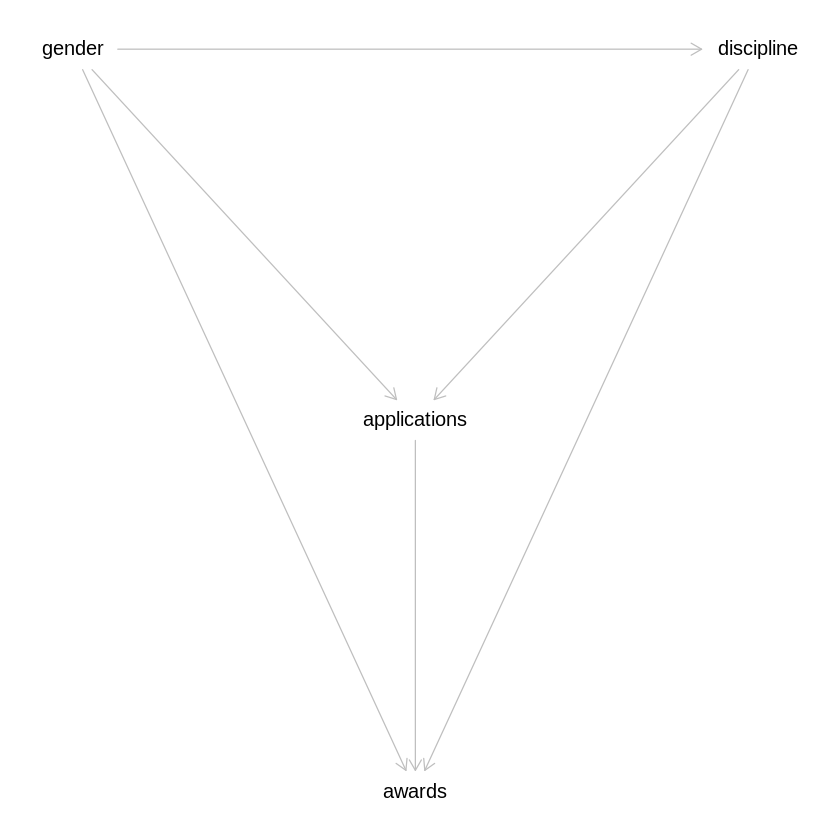

In [16]:
grants_dag <- dagitty(
                    "dag {
                            gender -> discipline -> awards
                            applications -> awards
                            gender -> awards
                            gender -> applications <- discipline
                        }"
                    )

coordinates( grants_dag ) <- list( x=c(gender=0,discipline=1,applications=0.5,awards=0.5) , y=c(gender=0,discipline=0,applications=0.5,awards=1) ) 

plot( grants_dag )

In [17]:
adjustmentSets( grants_dag , exposure="gender" , outcome="awards" )

 {}

In [19]:
impliedConditionalIndependencies( grants_dag )

Note, the DAG we have suggested shows there are no d-separations.

We are essentially modelling the following:

#awards ~ Binomial(applications (discipline(gender), gender), p(discipline(gender), gender))

Question - should we treat applications as a function of discipline and gender in this equation above, given that it is an observable and not a parameter?  Perhaps it is better to model p as a function of applications?

awards ~ Binomial(applications, p(applications, discipline, gender))

This would suggest that the probability of success depends on the number of applications, which makes some sense.  If there are few applications, there is less competition and grant awarding bodies may be more generous in their allocation of funds.  If there are many applications, grant awarding bodies with limited funds may be saturated and only allocate a fixed number of grants, thus reducing p.



There are several points in which gender can potentially influence the awards outcome: through the probability of success or through the number of trials (number of applications).

There are multiple ways gender can influence both parameters:

<b>Influence of p:</b>
* Directly, p = p(gender), which reflects discrimination of judges.
* Indirectly through choice of discipline, p = p(discipline(gender)): some disciplines may have a greater likelihood of success, and if some disciplines are more popular to (fe)males, gender will indireclty influence the probability of success.

<s><b>Influence of applications:</b>
* Directly, applications = applications(gender), which reflects the idea that one particular gender may make more applications.
* Indirectly through choice of discipline, applications = applications(discipline(gender)): some disciplines may make more applications, and if some disciplines are more popular to (fe)males, gender will indirectly influence the number of applications.</s>

The total causal influence of gender on awards can be assessed by merely regressing awards on gender.

The DAG above suggests discipline is a pipe, applications is a collider.

When regressing awards on gender, we have the choice to control for a) discipline, b) applications:  

a) If we control for discipline, we block the back-door path of gender to applications via discipline and the back-door path of gender to awards via discipline. If we don't control for discipline, the back-door path is open for gender to influence awards indirectly through discipline and applications indirectly through discipline. 

b) If we control for applications, we open the back-door path of influence between gender and discipline on applications.  However, if we control for discipline, this should have no effect on awards.  If we don't control for applications, then gender can influence awards indirectly through applications.

So in conclusion, to block all back-door paths from gender to awards, we must control for BOTH applications and discipline.  This will allow us to learn the direct causal path from gender to awards.

How do we measure the <b>indirect</b> causal paths from gender to awards, as the question actually asks?  There are two paths, via applications and via discipline.  Let's discuss each one in turn:

1) via applications: If we control for discipline but NOT applications, we block the backdoor path from gender to awards via discipline, thus leaving only the direct path from gender to awards AND from gender to awards via discipline.  We could then compare the indexed intercepts a[gender] from this regression with the a[gender] from the regression where we control for both discpiline and applications, which provides the direct causal path from gender to awards.  This would give us some information about the strength of influence of gender on awards via applications.  However, is this really what the question is asking us to answer?

2) via discipline: If we control for applications but NOT discipline, we block the backdoor path from gender to awards via applications and the backdoor path from gender to awards via applications.  However, as applications is a collider, we open the backdoor path from gender to discipline.  This doesn't matter though, as all we are interested in is the backdoor path from gender to awards via discipline, so we want to include both the direct causal path from gender to discipline, and the indirect causal path from gender to discipline via applications.  Again, the indirect causal path from gender to awards via discipline can be inferred by comparing the a[gender] from this regression (controlling for applications but not discipline) with a[gender] from the regression where we control for both discipline and applications, which provides the direct causal path from gender to awards.  This would give us some information abou tthe strenght of influence of gender on awards via discipline.  Again though, is this really what the question is asking us to answer?

At the end of the day, number of trials (applications) is observed, so all inference is about the paramter p = p(gender, discipline, applications).

We need to design the link function to express this.

There will be the main effects

In [33]:
#Enumerate cases for indexing:

d$D <- rep(1:9, each=2)
d$G <- rep(1:2, times=9)
#d$DG <- rep(1:18)    #This would be for an interaction between gender and discipline, meaning that gender influences how much discipline affects p, or discipline influences how much gender affects p.
d$applications_std <- standardize(d$applications)
d

discipline,gender,applications,awards,D,G,DG,applications_std
<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<dbl>
Chemical sciences,m,83,22,1,1,1,-0.617732260
Chemical sciences,f,39,10,1,2,2,-0.985861643
Physical sciences,m,135,26,2,1,3,-0.182670262
Physical sciences,f,39,9,2,2,4,-0.985861643
Physics,m,67,18,3,1,5,-0.751597490
Physics,f,9,2,3,2,6,-1.236858950
Humanities,m,230,33,4,1,7,0.612154542
Humanities,f,166,32,4,2,8,0.076693621
Technical sciences,m,189,30,5,1,9,0.269124890


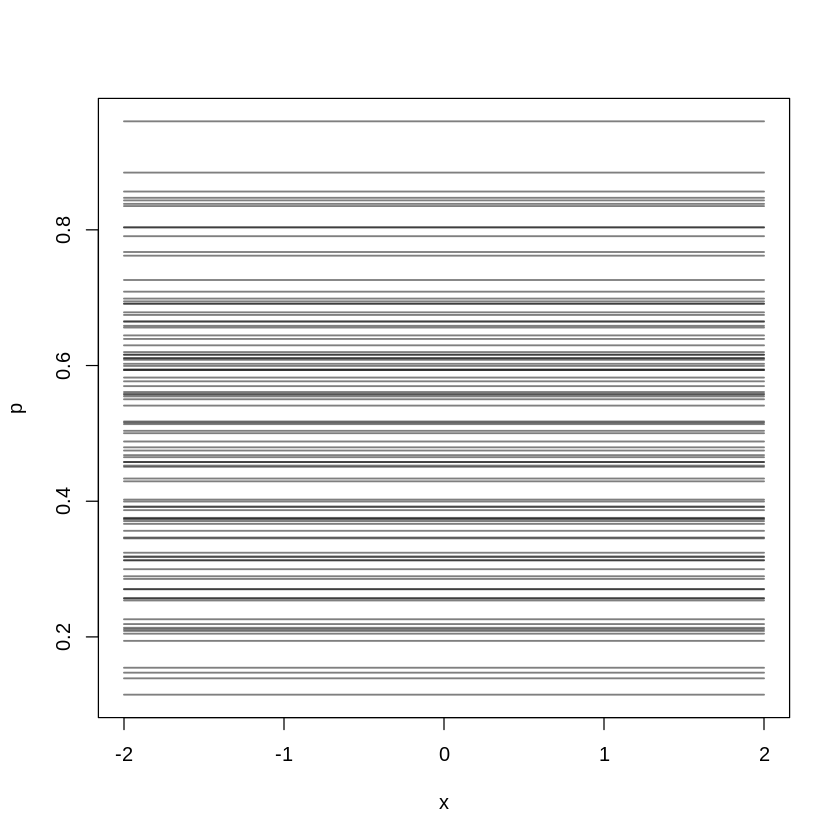

In [47]:
N <- 1e2

bG <- rnorm( N , 0 , 1 )
bD <- rnorm( N , 0 , 1 )
bA <- rnorm( N , 0 , 1 )

x_seq <- seq( from=-2 , to=2 , length.out=100 )
# p <- sapply( x_seq , function(x) inv_logit( bG + bD + bA*x ) )
p <- sapply( x_seq , function(x) inv_logit( bG ) )

plot( NULL , xlim=range(x_seq) , ylim=range(p) , xlab="x" , ylab="p")
for ( i in 1:N ) lines( x_seq , p[i,] , col=col.alpha("black",0.5) , lwd=1.5 )

In [63]:
m1 <- quap(
            alist(
                awards ~ dbinom( applications , p ) ,
                logit(p) <- bG[G] ,
                bG[G] ~ dnorm( 0 , 1 )
            ) , data=d )

precis(m1, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
bG[1],-1.527958,0.06447794,-1.631006,-1.424910
bG[2],-1.731091,0.08088688,-1.860364,-1.601818


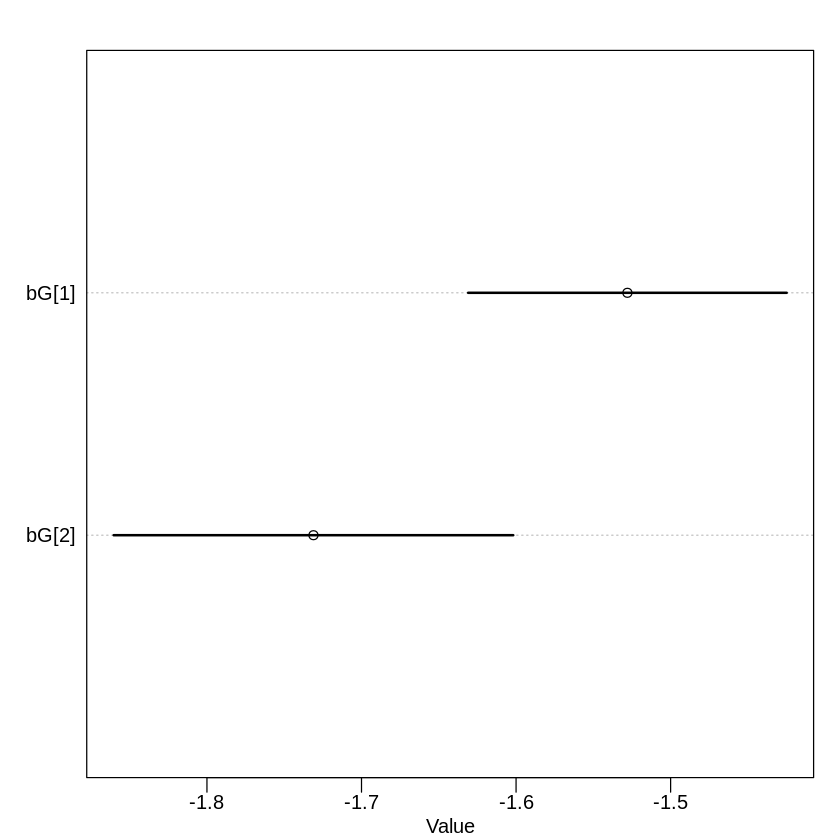

In [69]:
plot(precis(m1, depth=2))

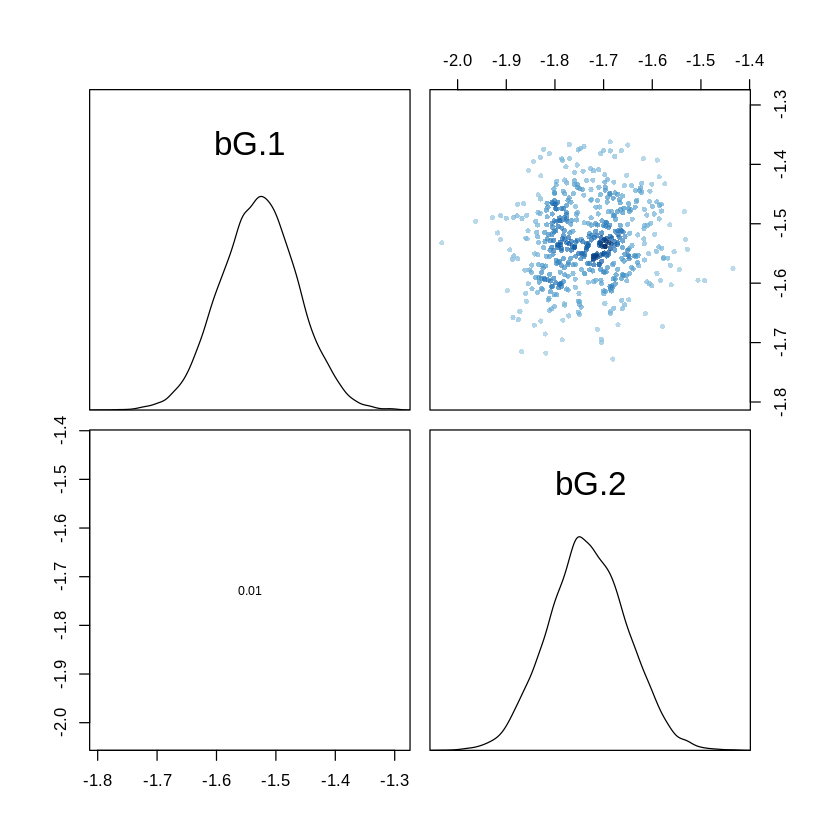

In [88]:
pairs(m1)

In [64]:
inv_logit(coef(m1))

bG[1]     bG[2] 
0.1782926 0.1504481

This suggests the average success rate for males is 18%, while the average for females is 15%.  The contrast is around 3% for males - females:

[1] 0.02765575

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
diff1,0.02765575,0.01400219,0.004923126,0.04970946,▁▁▁▂▅▇▇▃▁▁▁


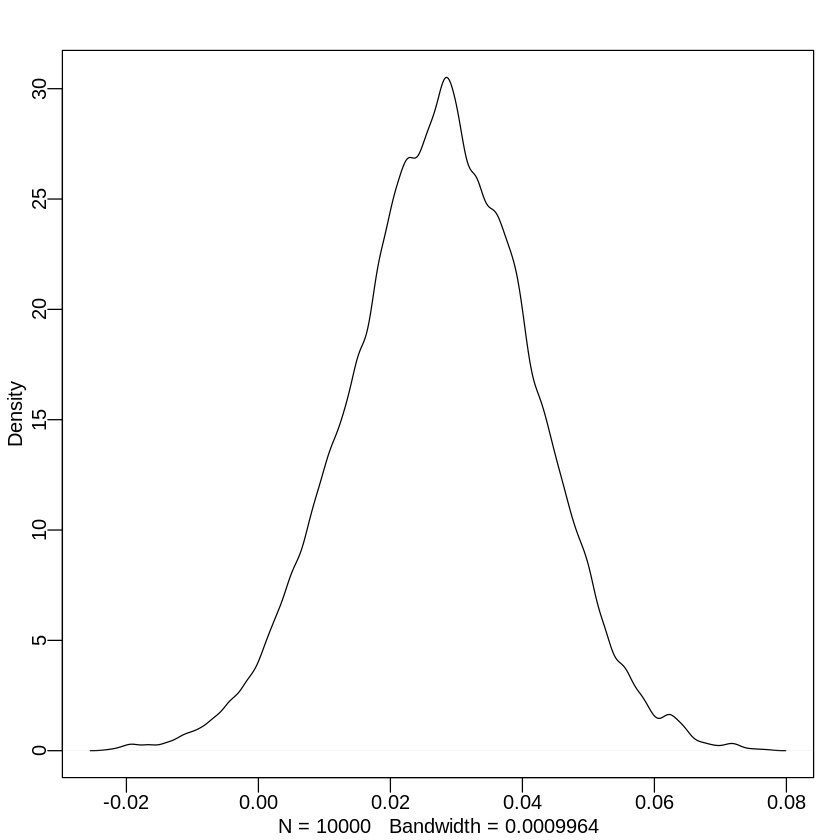

In [65]:
post1 <- extract.samples(m1)
diff1 <- inv_logit(post1$bG[,1]) - inv_logit(post1$bG[,2])
mean(diff1)
precis(diff1)
dens(diff1)

This could be interpreted as the total causal effect (including all back-door effects) of gender on probability of award.

In [71]:
#As discussed before, this should block the back-door path of gender to award through discipline, so bG could now be interpreted as the direct causal influence of gender on award and causal influence via applications.
m2 <- quap(
            alist(
                awards ~ dbinom( applications , p ) ,
                logit(p) <- bG[G] + bD[D],
                bG[G] ~ dnorm( 0 , 1 ),
                bD[D] ~ dnorm( 0 , 1 )
            ) , data=d )

precis(m2, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
bG[1],-1.1559436,0.3078048,-1.6478750,-0.664012140
bG[2],-1.2919184,0.3125647,-1.7914571,-0.792379702
bD[1],0.1576800,0.3557910,-0.4109428,0.726302767
bD[2],-0.1869799,0.3486797,-0.7442375,0.370277664
bD[3],0.1329180,0.3823152,-0.4780956,0.743931563
bD[4],-0.4087894,0.3284490,-0.9337144,0.116135546
bD[5],-0.3773709,0.3399190,-0.9206272,0.165885348
bD[6],-0.4393902,0.3535885,-1.0044928,0.125712460
bD[7],-0.1759427,0.3331429,-0.7083694,0.356484098


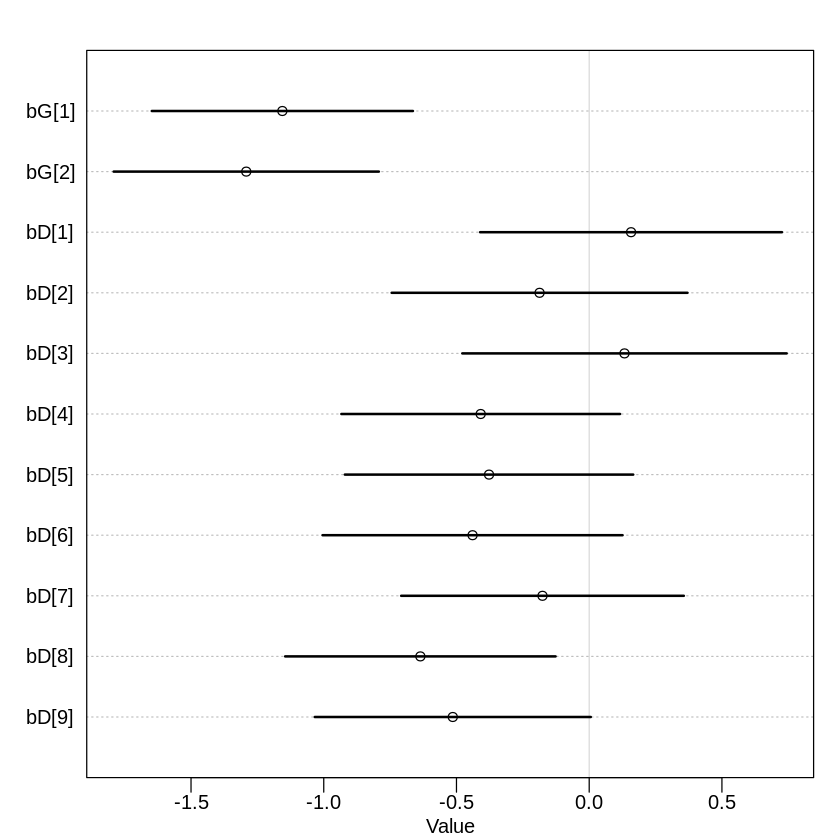

In [73]:
plot(precis(m2, depth=2))

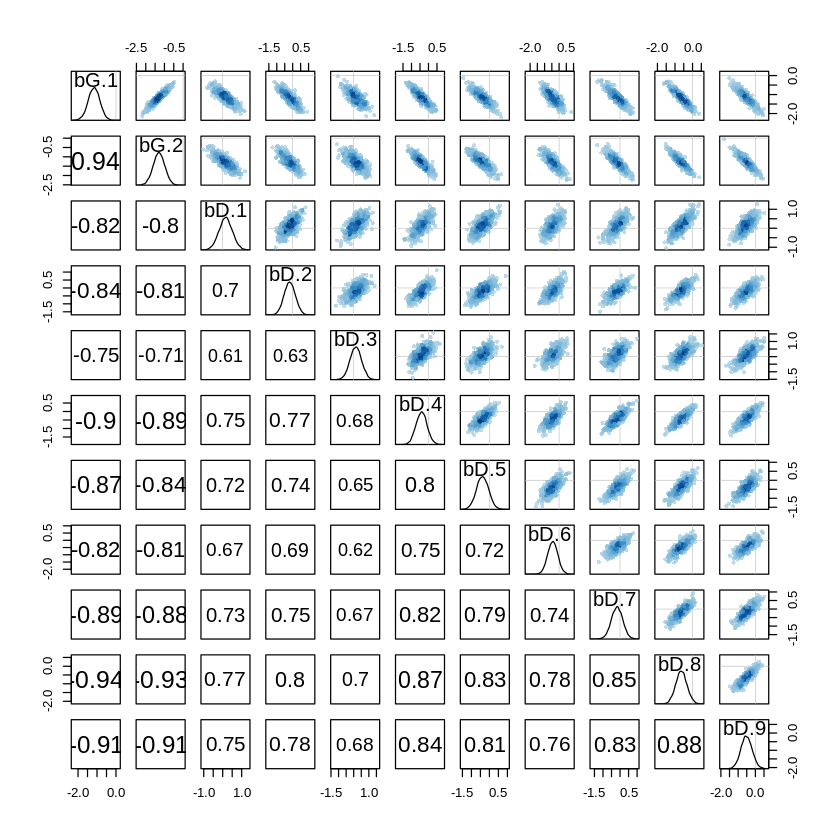

In [87]:
pairs(m2)

In [75]:
inv_logit(coef(m2))

bG[1]     bG[2]     bD[1]     bD[2]     bD[3]     bD[4]     bD[5]     bD[6] 
0.2394051 0.2155283 0.5393385 0.4533907 0.5331807 0.3992024 0.4067612 0.3918863 
    bD[7]     bD[8]     bD[9] 
0.4561275 0.3461423 0.3742699

This suggests, taking into account discipline, the average probability of grant award success is 24% for males and 22% for females.  The contrast has a mean of 2.4% in favour of males, controlling for discipline.

[1] 0.02376088

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
diff2,0.02376088,0.01901129,-0.005842362,0.05451269,▁▁▂▇▇▃▁▁▁


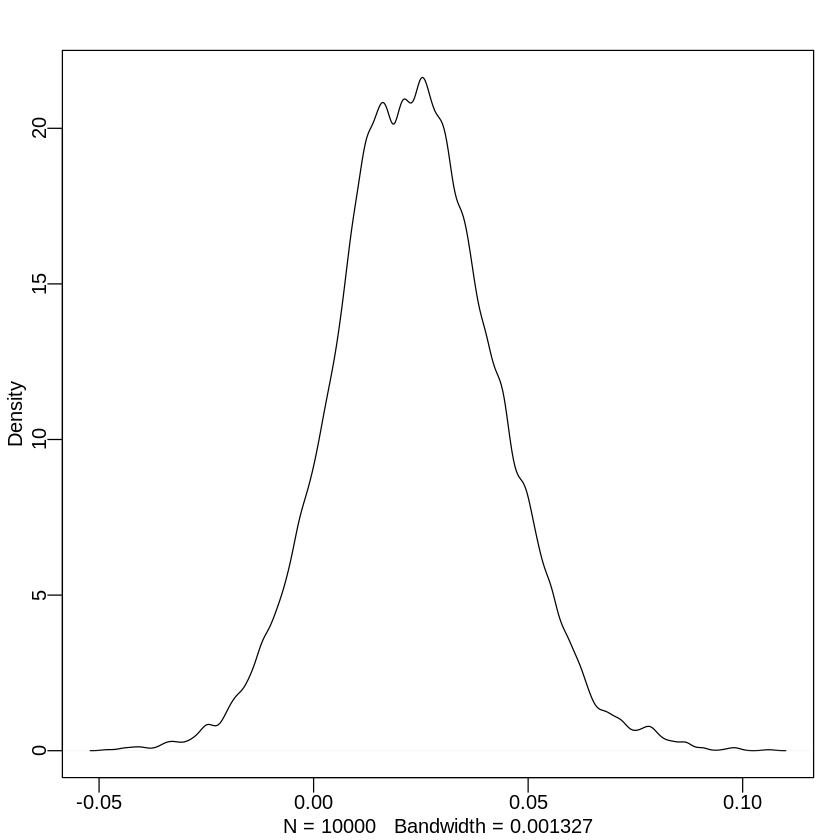

In [76]:
post2 <- extract.samples(m2)
diff2 <- inv_logit(post2$bG[,1]) - inv_logit(post2$bG[,2])
mean(diff2)
precis(diff2)
dens(diff2)

In [77]:
m3 <- quap(
            alist(
                awards ~ dbinom( applications , p ) ,
                logit(p) <- bG[G] + bA*applications_std,
                bG[G] ~ dnorm( 0 , 1 ),
                bA ~ dnorm( 0 , 1 )
            ) , data=d )

precis(m3, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
bG[1],-1.3974617,0.07051198,-1.510153,-1.2847699
bG[2],-1.5993979,0.08560235,-1.736207,-1.4625888
bA,-0.2047579,0.04914306,-0.283298,-0.1262178


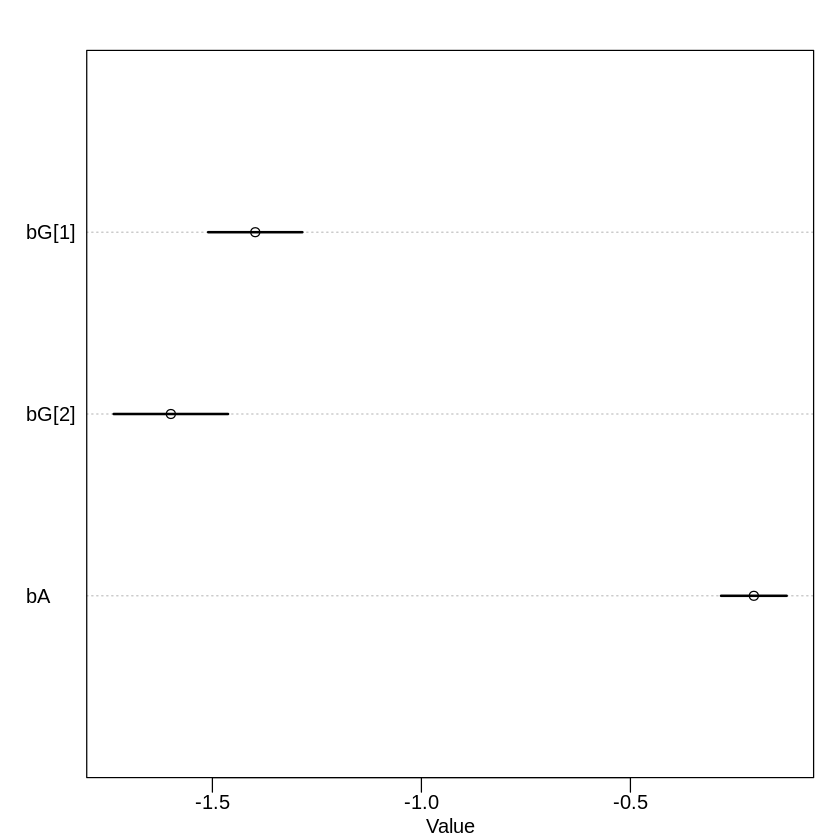

In [78]:
plot(precis(m3, depth=2))

This suggests that there is a negative effect for applications - a 1 standard deviation increase in applications leads to a reduction in log(odds) of award success of 0.2.  Due to non-linearities, it is difficult to interpret this effect on probability.

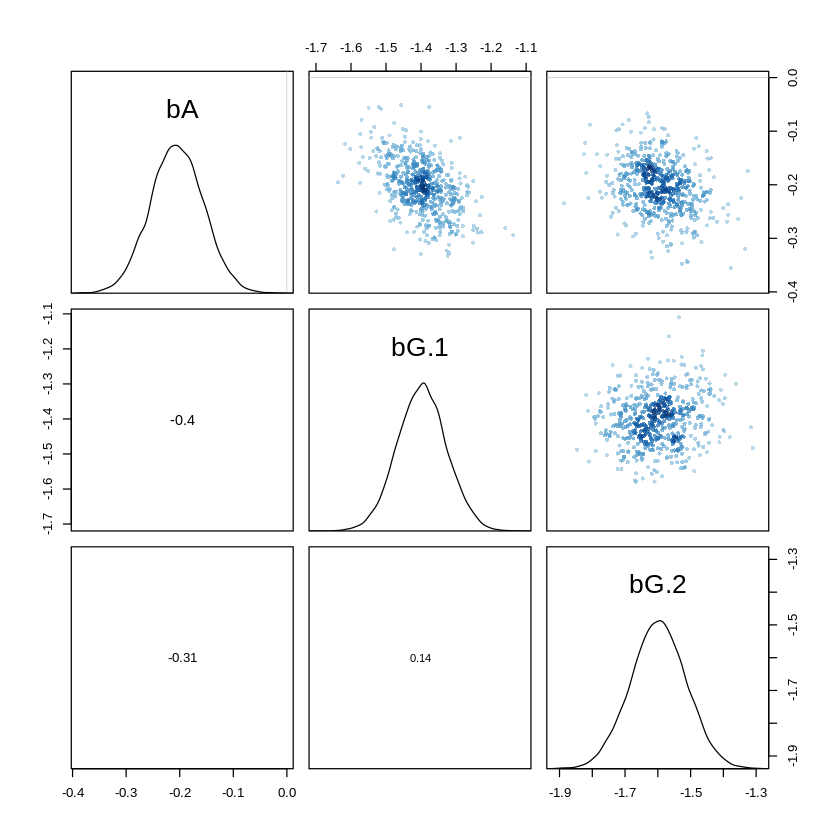

In [89]:
pairs(m3)

[1] 0.02991949

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
diff3,0.02991949,0.01515208,0.005785003,0.05400268,▁▁▁▂▅▇▇▅▂▁▁▁▁


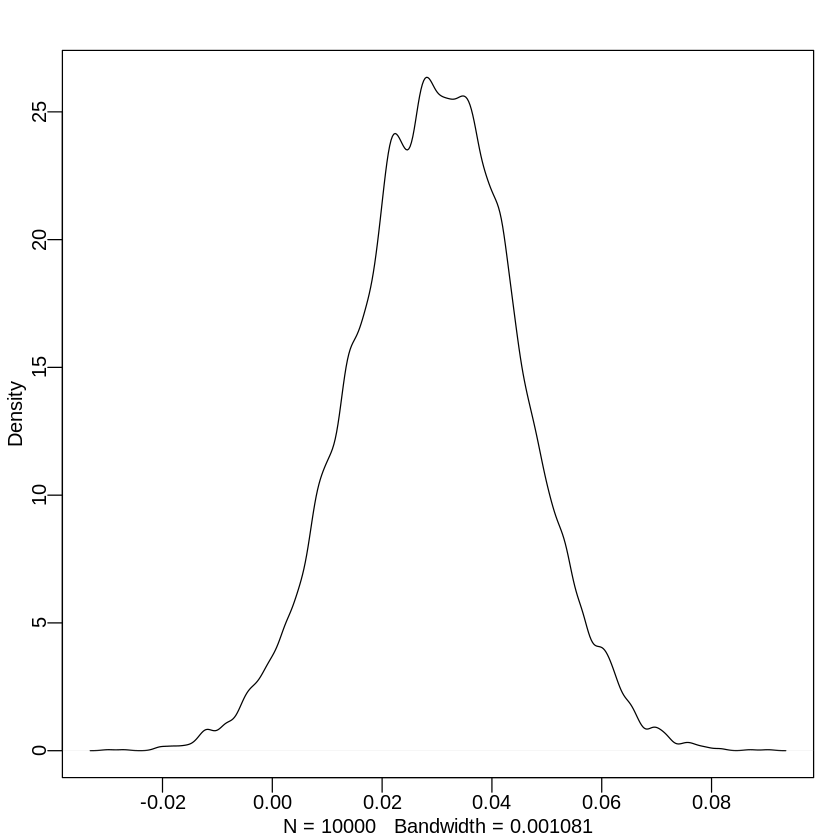

In [82]:
post3 <- extract.samples(m3)
diff3 <- inv_logit(post3$bG[,1]) - inv_logit(post3$bG[,2])
mean(diff3)
precis(diff3)
dens(diff3)

In [84]:
inv_logit(coef(m3))

bG[1]     bG[2]        bA 
0.1982192 0.1680658 0.4489886

This suggests, controlling for the application numbers, there is a 20% probability of success for males and 17% success rate for females, with an average 3% contrast between the distributions for males and females, favouring males.

As discussed abouve, this represents the causal effect of gender directly and through the back-door of discipline.

In order to control for all back-doors, we must control for both discipline and applications, which we do now:

In [85]:
m4 <- quap(
            alist(
                awards ~ dbinom( applications , p ) ,
                logit(p) <- bG[G] + bD[D] + bA*applications_std,
                bG[G] ~ dnorm( 0 , 1 ),
                bD[D] ~ dnorm( 0 , 1 ),
                bA ~ dnorm( 0 , 1 )
            ) , data=d )

precis(m4, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
bG[1],-1.04386753,0.3110008,-1.5409069,-0.54682816
bG[2],-1.34880194,0.3133203,-1.8495483,-0.84805562
bD[1],-0.31123541,0.4012471,-0.9525058,0.33003495
bD[2],-0.46449894,0.3658446,-1.0491892,0.12019136
bD[3],-0.39728435,0.4358442,-1.0938476,0.29927887
bD[4],-0.22458146,0.3366846,-0.7626685,0.31350554
bD[5],-0.44695831,0.3412517,-0.9923444,0.09842778
bD[6],-0.77748420,0.3777545,-1.3812089,-0.17375949
bD[7],-0.28053644,0.3355603,-0.8168267,0.25575378


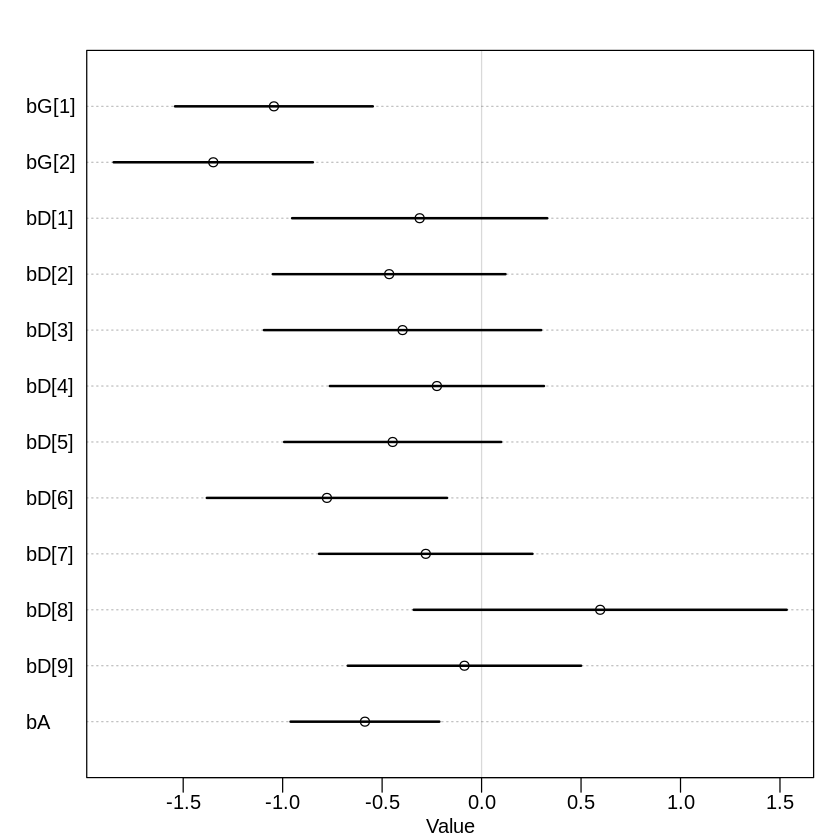

In [86]:
plot(precis(m4, depth=2))

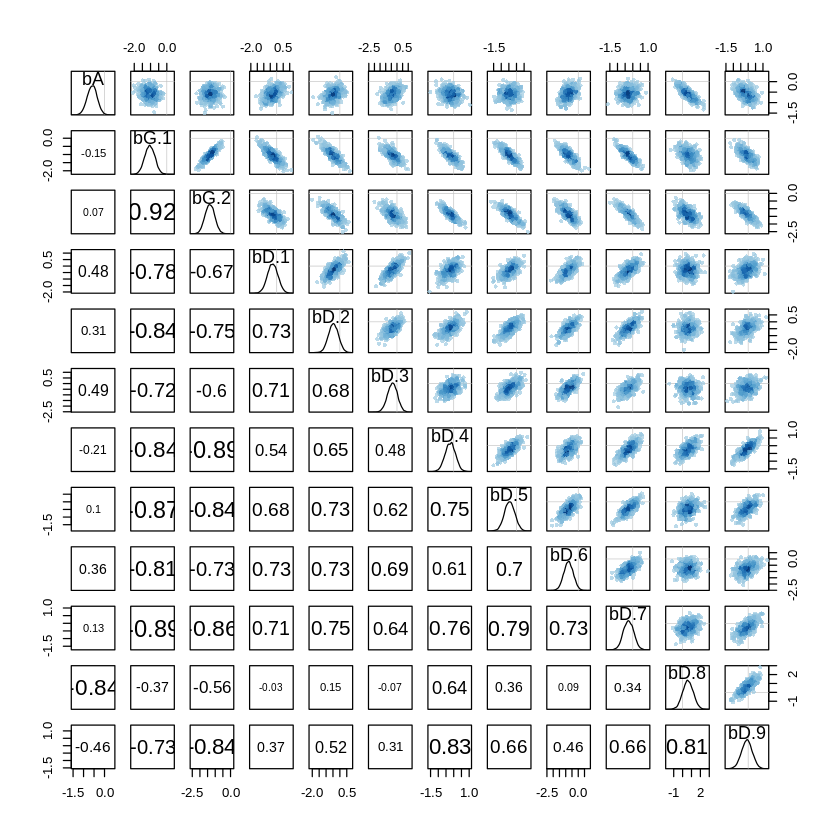

In [90]:
pairs(m4)

Note the large correlations.  This may be because we have an extra degree of freedom using index variables, i.e. an index for male and female, rather than a baseline.  The same is true for discipline.  The unusual thing is that bG[1] was not correlated with bG[2] when discipline was not controlled for.

In [93]:
inv_logit(coef(m4))

bG[1]     bG[2]     bD[1]     bD[2]     bD[3]     bD[4]     bD[5]     bD[6] 
0.2604044 0.2060663 0.4228132 0.3859191 0.4019650 0.4440894 0.3900842 0.3148624 
    bD[7]     bD[8]     bD[9]        bA 
0.4303223 0.6447838 0.4784622 0.3574626

[1] 0.05400474

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
diff4,0.05400474,0.02412791,0.01699654,0.09376086,▁▁▁▅▇▅▂▁▁▁▁


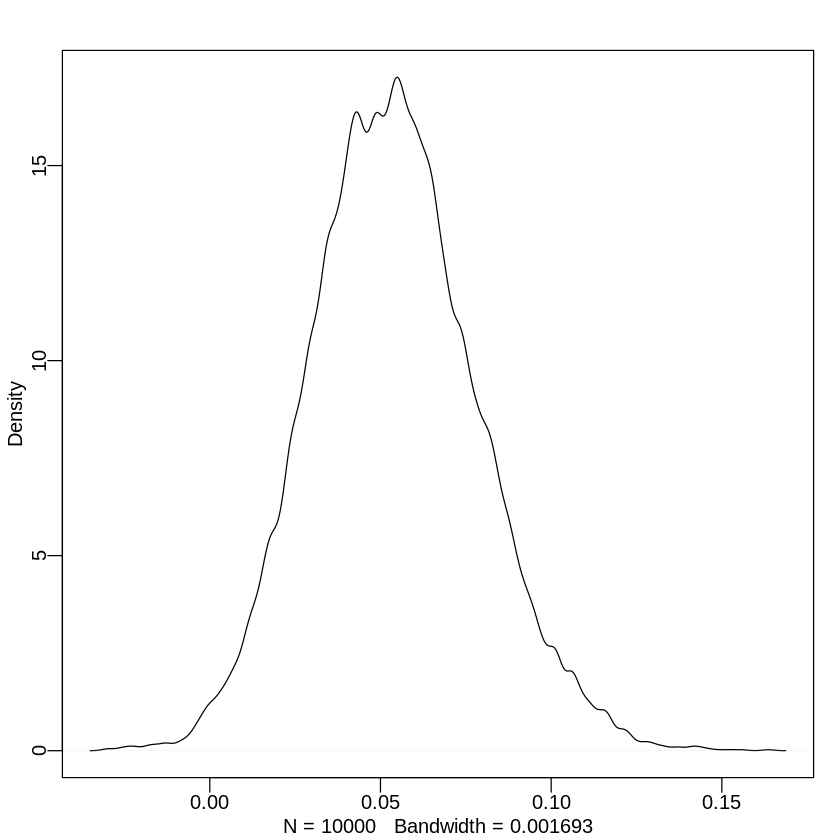

In [94]:
post4 <- extract.samples(m4)
diff4 <- inv_logit(post4$bG[,1]) - inv_logit(post4$bG[,2])
mean(diff4)
precis(diff4)
dens(diff4)

The advantage of males over females becomes even stronger when we control for discipline and applications, with males having an advantage of 5.4% over females.

Perhaps we should consider the interaction between discipline and gender, so we add the term DG:

In [95]:
m5 <- quap(
            alist(
                awards ~ dbinom( applications , p ) ,
                logit(p) <- bG[G] + bD[D] + bDG[DG] + bA*applications_std,
                bG[G] ~ dnorm( 0 , 1 ),
                bD[D] ~ dnorm( 0 , 1 ),
                bDG[DG] ~ dnorm( 0 , 0.2 ),
                bA ~ dnorm( 0 , 1 )
            ) , data=d )

precis(m5, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
bG[1],-1.0786727537,0.3186377,-1.5879173,-0.56942823
bG[2],-1.3059133838,0.3221499,-1.8207711,-0.79105569
bD[1],-0.2040782407,0.4337477,-0.8972908,0.48913430
bD[2],-0.3859223051,0.3985550,-1.0228901,0.25104550
bD[3],-0.2754252367,0.4757227,-1.0357220,0.48487155
bD[4],-0.2561807454,0.3631926,-0.8366326,0.32427111
bD[5],-0.4148977164,0.3692564,-1.0050407,0.17524531
bD[6],-0.6753938004,0.4038512,-1.3208261,-0.02996151
bD[7],-0.2800623368,0.3607200,-0.8565626,0.29643788


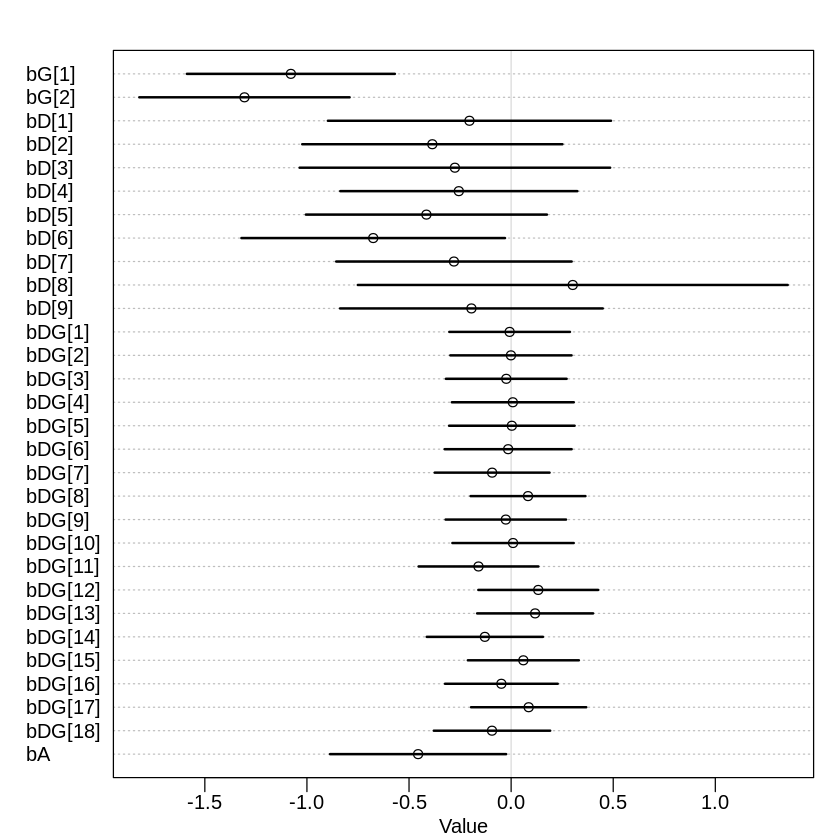

In [97]:
plot(precis(m5, depth=2))

In [100]:
inv_logit(coef(m5))

bG[1]     bG[2]     bD[1]     bD[2]     bD[3]     bD[4]     bD[5]     bD[6] 
0.2537573 0.2131715 0.4491568 0.4046993 0.4315757 0.4363028 0.3977383 0.3372901 
    bD[7]     bD[8]     bD[9]    bDG[1]    bDG[2]    bDG[3]    bDG[4]    bDG[5] 
0.4304385 0.5748798 0.4515500 0.4981796 0.4997800 0.4940528 0.5020869 0.5008819 
   bDG[6]    bDG[7]    bDG[8]    bDG[9]   bDG[10]   bDG[11]   bDG[12]   bDG[13] 
0.4963636 0.4767644 0.5206789 0.4934992 0.5023529 0.4601238 0.5331586 0.5293294 
  bDG[14]   bDG[15]   bDG[16]   bDG[17]   bDG[18]        bA 
0.4678784 0.5149593 0.4880519 0.5214667 0.4765951 0.3880375

[1] 0.04045943

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
diff5,0.04045943,0.03166283,-0.008531106,0.09100233,▁▁▁▁▂▅▇▇▅▂▁▁▁▁


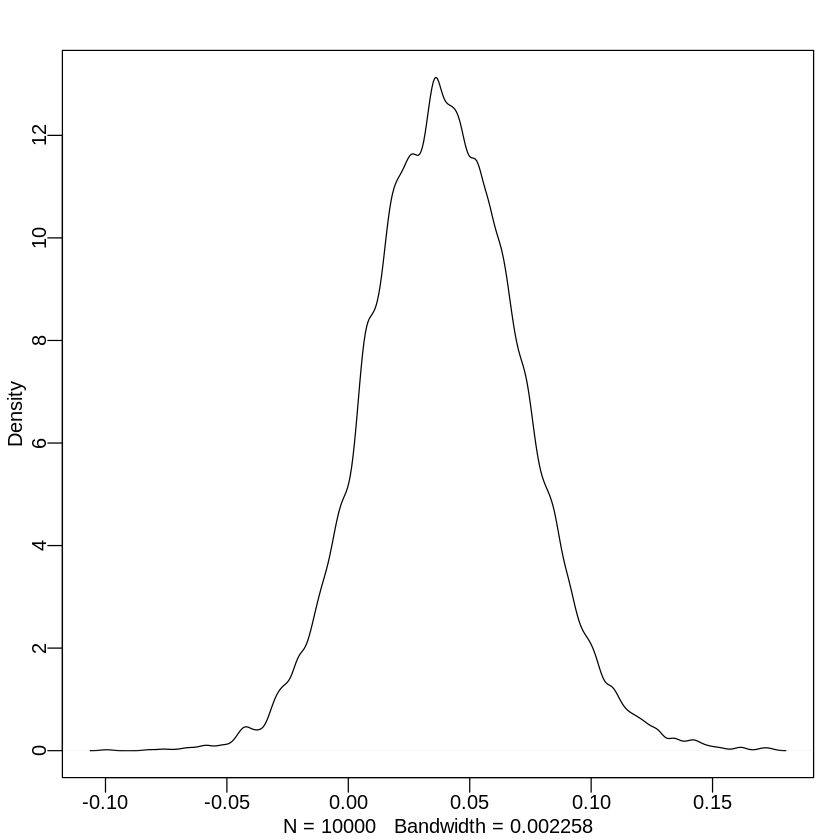

In [101]:
post5 <- extract.samples(m5)
diff5 <- inv_logit(post5$bG[,1]) - inv_logit(post5$bG[,2])
mean(diff5)
precis(diff5)
dens(diff5)

Including the interaction between discipline and gender reduces the advantage males have over females, however the contrast still averages 4% advantage for males.

In [164]:
m6 <- quap(
            alist(
                awards ~ dbinom( applications , p ) ,
                logit(p) <- bDG[DG] + bA*applications_std ,
#                bG[G] ~ dnorm( 0 , 1 ),
#                bD[D] ~ dnorm( 0 , 1 ),
                bA ~ dnorm( 0 , 1 ),
#                bDG[DG] ~ dnorm( 0 , 0.2 ),
                bDG[DG] ~ dnorm( 0 , 0.5 )
            ) , data=d )

precis(m6, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
bA,-0.4025160,0.1322174,-0.6138251,-0.1912070
bDG[1],-1.0274576,0.2238884,-1.3852745,-0.6696407
bDG[2],-0.9838497,0.2920668,-1.4506289,-0.5170705
bDG[3],-1.2790690,0.1902993,-1.5832040,-0.9749340
bDG[4],-1.0616543,0.2940214,-1.5315572,-0.5917513
bDG[5],-1.0142849,0.2435631,-1.4035458,-0.6250240
bDG[6],-0.5792432,0.4044181,-1.2255813,0.0670950
bDG[7],-1.3597366,0.1815019,-1.6498117,-1.0696615
bDG[8],-1.2219312,0.1751254,-1.5018154,-0.9420470


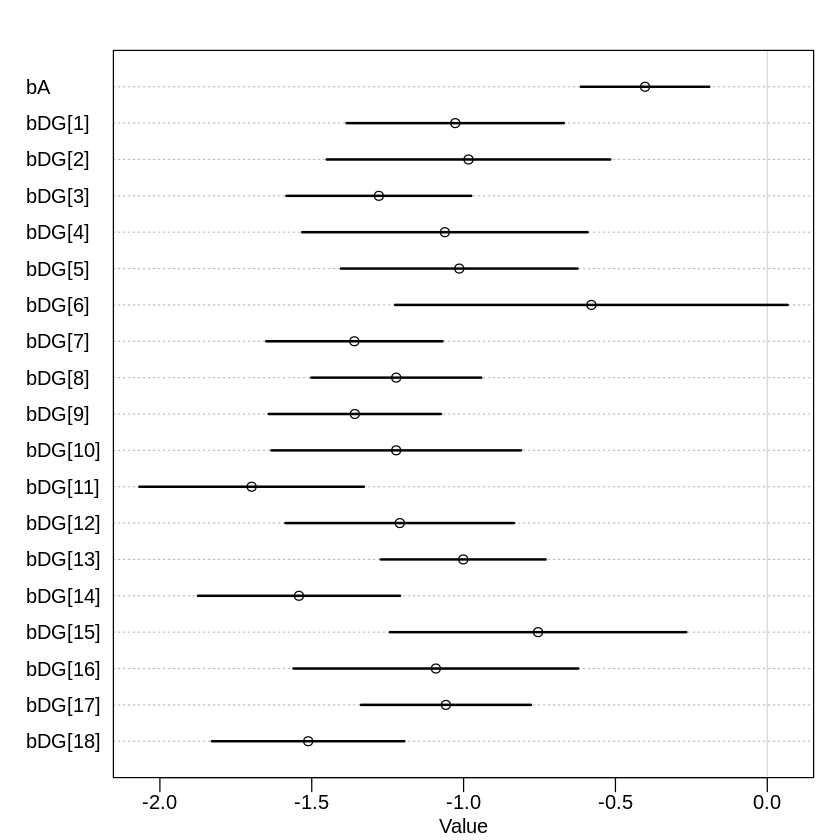

In [165]:
plot(precis(m6, depth=2))

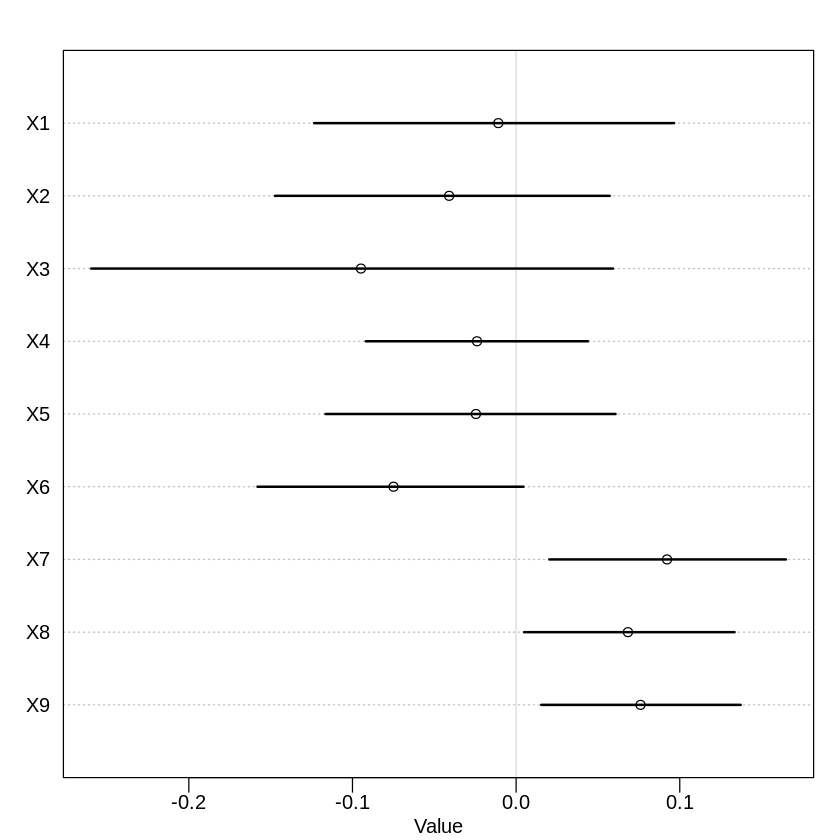

In [166]:
post6 <- extract.samples(m6)

#diff6 <- sapply( 1:9 , function(k) ( post6$bDG[,(2*k)-1] - post6$bDG[,2*k] ) )
diff6_p <- sapply( 1:9, function(k) (inv_logit(post6$bDG[,(2*k)-1]) - inv_logit(post6$bDG[,2*k])))
                
diff6_p <- data.frame(diff6_p)
                 
plot(precis(diff6_p))

This shows the constrast in probability space across the disciplines, controlling for applications.  When positive, applications from males are more likely to succeed than from females.  From this analysis, there is no consistent bias against females or males.  It appears depend on discipline, but almost all distributions are near to zero.  The most extreme discipline to favour females is number 3, Physics, where females appear to be at a significant advantage compared to males.  If we look at the data though, there were only 9 applications from female Physicists, so the sample space is very small, as reflected in the greater uncertainty of the p distribution.  Females also appear more likely to be awarded in interdisciplinary subjects.

Males appear to have a significant advantage in the earth/life sciences, social sciences and medicine.  As these disciplines also tend to grant more awards, this is probably why, on average, males appear to have a higher probability of success.

"What is your causal interpretation? If NWO’s goal is to equalize rates of funding
between the genders, what type of intervention would be most effective?"

Encourage more grant applications from Physics and Interdisciplinary disciplines.  This could perhaps be done by increasing the funding (i.e. grant more awards) for these disciplines.

In [167]:
compare(m1, m2, m3, m4, m5, m6, func=LOO)

,LOO,pLOO,dLOO,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m3,2517.599,3.045318,0.000000,7.585195e-01,63.60536,NA
m5,2520.846,13.185291,3.247972,1.495129e-01,63.85147,6.218367
m4,2521.952,10.416314,4.353847,8.600842e-02,63.90289,5.621417
m2,2527.436,9.720651,9.837325,5.543944e-03,63.90925,5.242412
m1,2532.632,2.038416,15.033966,4.124606e-04,63.70699,8.570601
m6,2542.655,13.063974,25.056835,2.747541e-06,57.24568,12.414586


m6 seems to be a poor predictive model, as can also be observed using postcheck for m6 and the other models.  m3, appears to be the best model, although m4 and m5 also do almost as good a job, but have a lot more effective parameters compared to m3.  Strangely, m3 is the model that does not control for discipline.  This would suggest that most variation in awards can be explained by gender and applications.

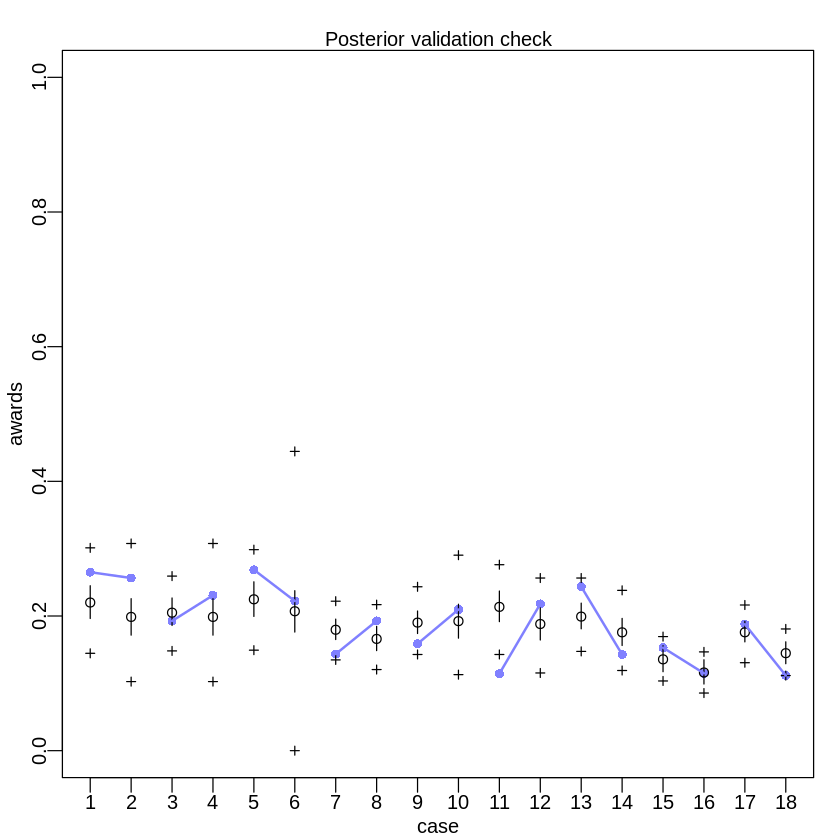

In [173]:
postcheck(m3)
# draw lines connecting points from same discipline
for ( i in 1:9 ) {
x <- 1 + 2*(i-1)
y1 <- d$awards[x]/d$applications[x]
y2 <- d$awards[x+1]/d$applications[x+1]
lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
}

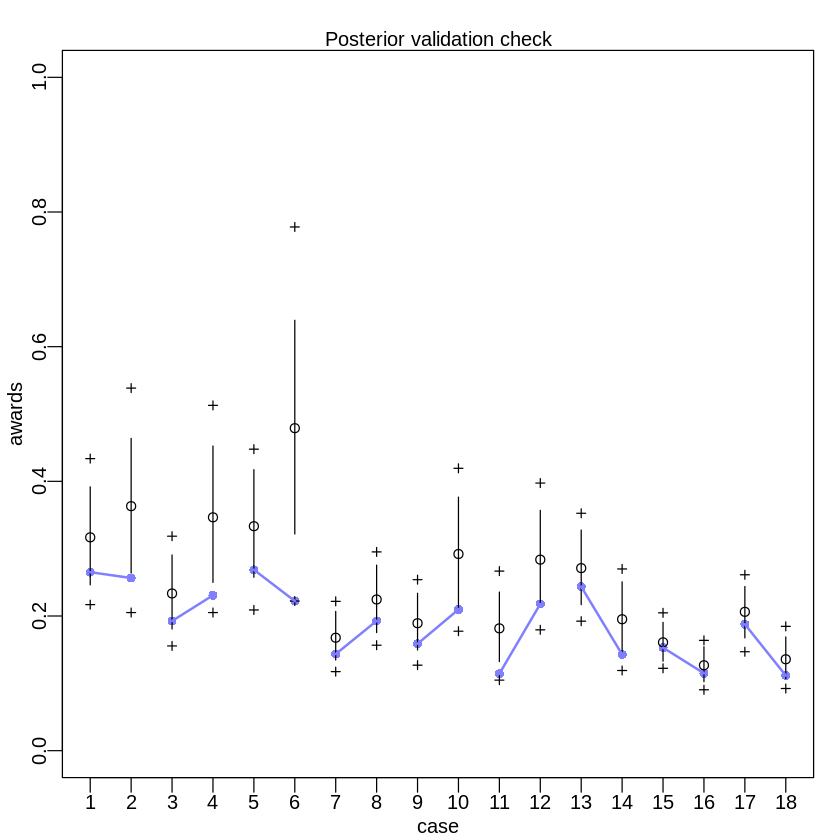

In [174]:
postcheck(m6)
# draw lines connecting points from same discipline
for ( i in 1:9 ) {
x <- 1 + 2*(i-1)
y1 <- d$awards[x]/d$applications[x]
y2 <- d$awards[x+1]/d$applications[x+1]
lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
}

In [169]:
m7 <- quap(
            alist(
                awards ~ dbinom( applications , p ) ,
                logit(p) <- bADG[DG] *applications_std ,
#                bG[G] ~ dnorm( 0 , 1 ),
#                bD[D] ~ dnorm( 0 , 1 ),
#                 bA ~ dnorm( 0 , 1 ),
#                bDG[DG] ~ dnorm( 0 , 0.5 ),
                bADG[DG] ~ dnorm( 0 , 0.5 )
            ) , data=d )

precis(m7, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
bADG[1],1.0330987,0.29929413,0.5547688,1.5114285
bADG[2],0.7147939,0.28408697,0.2607680,1.1688197
bADG[3],1.4808146,0.44255448,0.7735271,2.1881021
bADG[4],0.7951028,0.28679723,0.3367454,1.2534601
bADG[5],0.8875251,0.28303661,0.4351780,1.3398723
bADG[6],0.4197415,0.37215647,-0.1750364,1.0145194
bADG[7],-2.2032935,0.23504312,-2.5789378,-1.8276492
bADG[8],-0.9216268,0.48542576,-1.6974309,-0.1458227
bADG[9],-2.3745257,0.37541715,-2.9745148,-1.7745366


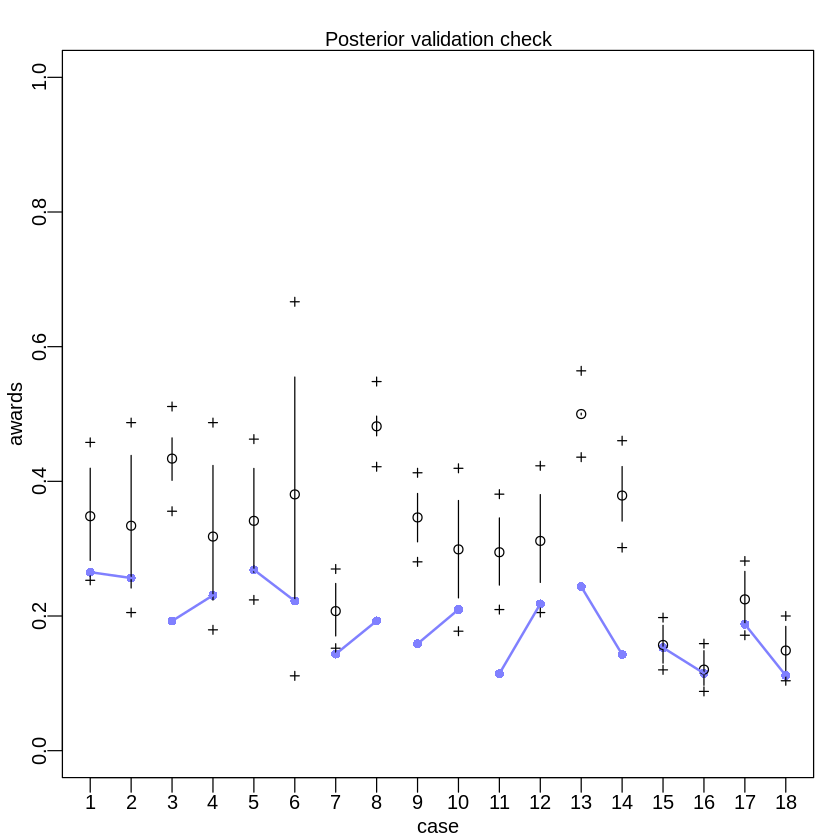

In [176]:
postcheck(m7)
# draw lines connecting points from same discipline
for ( i in 1:9 ) {
x <- 1 + 2*(i-1)
y1 <- d$awards[x]/d$applications[x]
y2 <- d$awards[x+1]/d$applications[x+1]
lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
}

In [178]:
m8 <- quap(
            alist(
                awards ~ dbinom( applications , p ) ,
                logit(p) <- bA *applications_std ,
#                bG[G] ~ dnorm( 0 , 1 ),
#                bD[D] ~ dnorm( 0 , 1 ),
                bA ~ dnorm( 0 , 1 )
#                bDG[DG] ~ dnorm( 0 , 0.5 ),
#                 bADG[DG] ~ dnorm( 0 , 0.5 )
            ) , data=d )

precis(m8, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
bA,-0.7898463,0.0386968,-0.8516912,-0.7280013


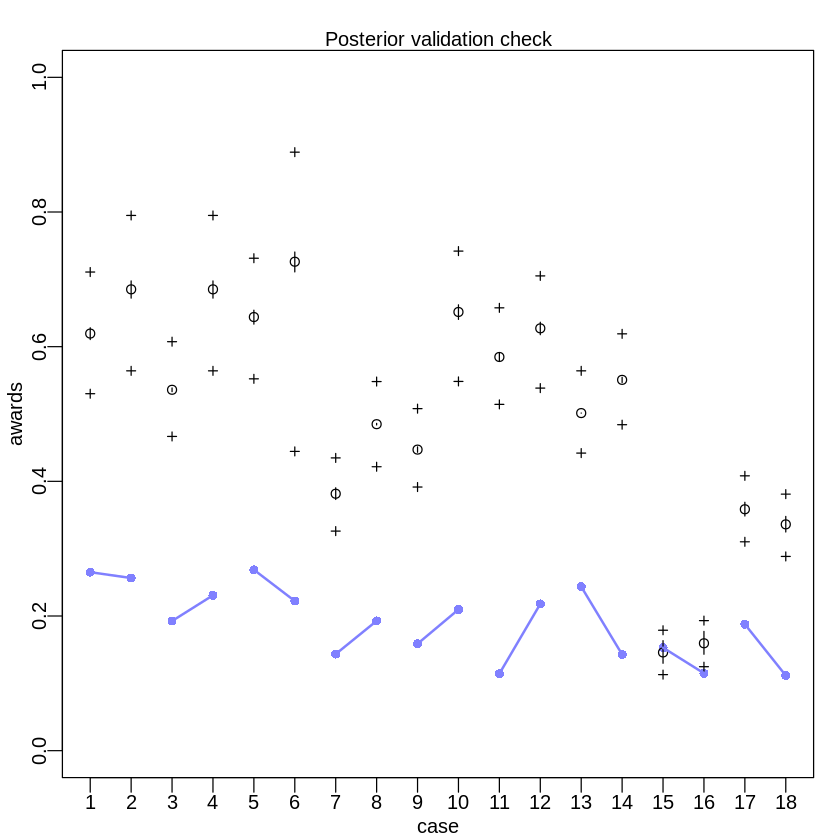

In [187]:
postcheck(m8)
# draw lines connecting points from same discipline
for ( i in 1:9 ) {
x <- 1 + 2*(i-1)
y1 <- d$awards[x]/d$applications[x]
y2 <- d$awards[x+1]/d$applications[x+1]
lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
}

In [183]:
m9 <- quap(
            alist(
                awards ~ dbinom( applications , p ) ,
                logit(p) <- bAG[G] *applications_std ,
#                bG[G] ~ dnorm( 0 , 1 ),
#                bD[D] ~ dnorm( 0 , 1 ),
                bAG[G] ~ dnorm( 0 , 1 )
#                bDG[DG] ~ dnorm( 0 , 0.5 ),
#                 bADG[DG] ~ dnorm( 0 , 0.5 )
            ) , data=d )

precis(m9, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
bAG[1],-0.8004477,0.05435393,-0.8873158,-0.7135796
bAG[2],-0.7763669,0.05498384,-0.8642417,-0.6884921


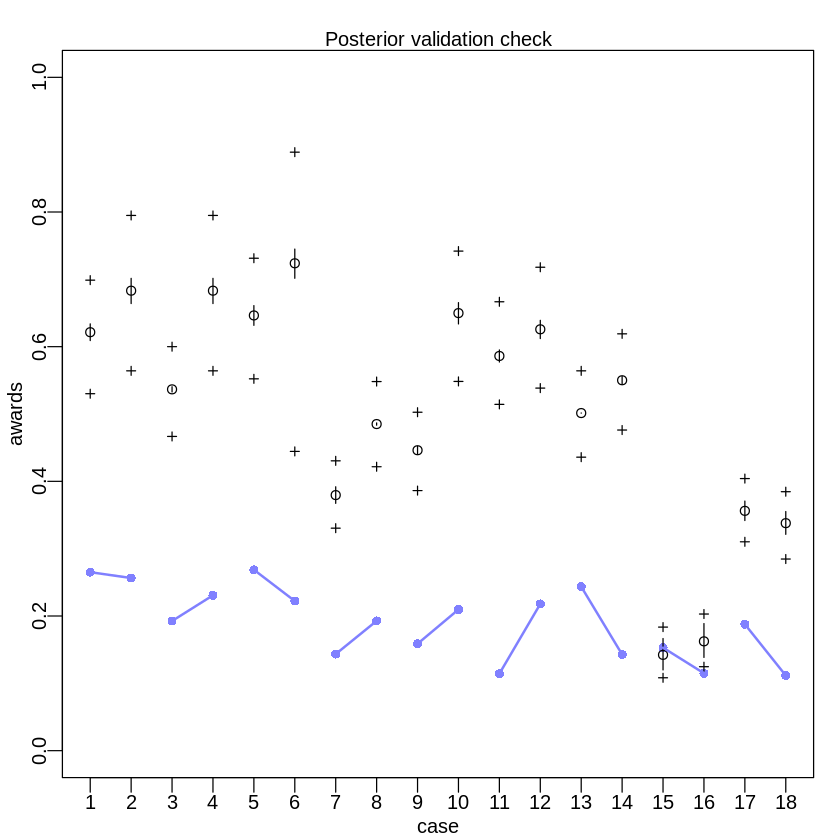

In [188]:
postcheck(m9)
# draw lines connecting points from same discipline
for ( i in 1:9 ) {
x <- 1 + 2*(i-1)
y1 <- d$awards[x]/d$applications[x]
y2 <- d$awards[x+1]/d$applications[x+1]
lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
}

In [189]:
compare(m1, m2, m3, m4, m5, m6, m7, m8, m9, func=LOO)

,LOO,pLOO,dLOO,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m3,2517.739,3.1210490,0.000000,6.993941e-01,63.74849,NA
m5,2520.296,12.9605786,2.557263,1.947240e-01,63.86085,6.318048
m4,2521.639,10.3111492,3.900618,9.947492e-02,64.00407,5.569259
m2,2527.254,9.6389051,9.515117,6.005379e-03,63.92815,5.254741
m1,2532.674,2.0489614,14.935628,3.994767e-04,63.61284,8.710385
m6,2543.120,13.1006272,25.381756,2.153494e-06,57.16720,12.369071
m7,2759.138,9.1180701,241.399083,2.664263e-53,49.32311,29.724189
m8,3365.415,0.9817747,847.676073,5.945681e-185,41.90073,53.091311
m9,3367.203,1.8902052,849.464238,2.431680e-185,41.80952,53.029861


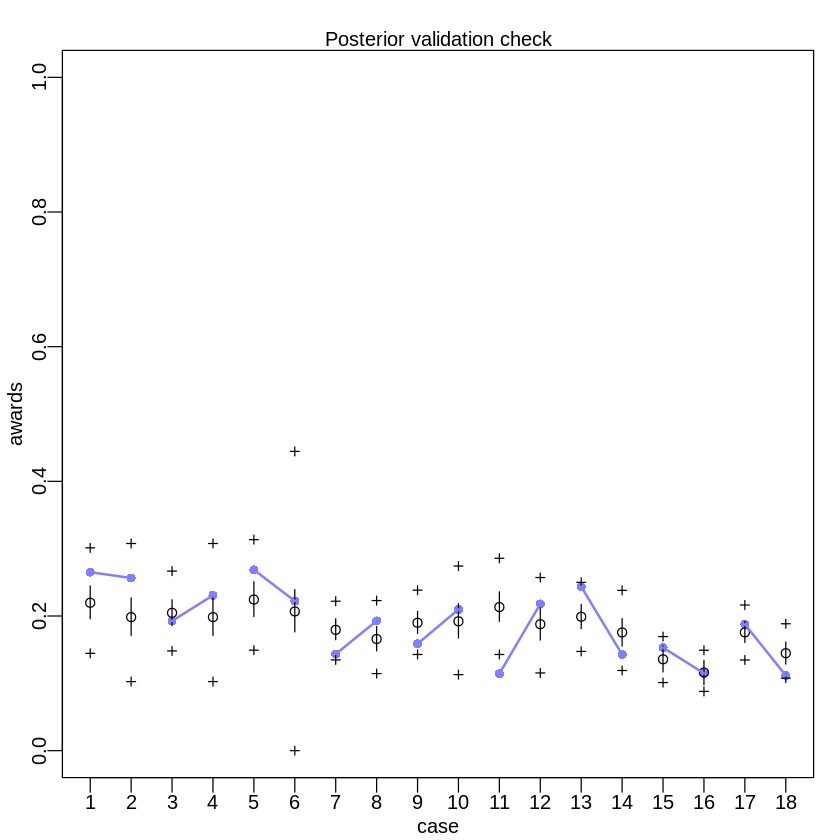

In [193]:
postcheck(m3)
# draw lines connecting points from same discipline
for ( i in 1:9 ) {
x <- 1 + 2*(i-1)
y1 <- d$awards[x]/d$applications[x]
y2 <- d$awards[x+1]/d$applications[x+1]
lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
}

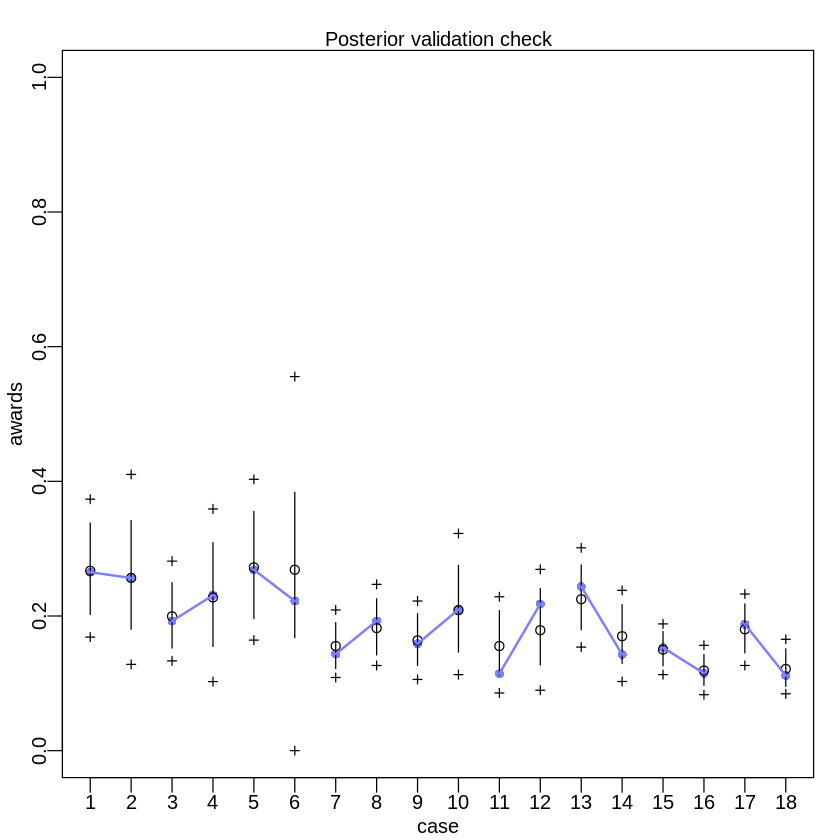

In [201]:
postcheck(m5)
# draw lines connecting points from same discipline
for ( i in 1:9 ) {
x <- 1 + 2*(i-1)
y1 <- d$awards[x]/d$applications[x]
y2 <- d$awards[x+1]/d$applications[x+1]
lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
}

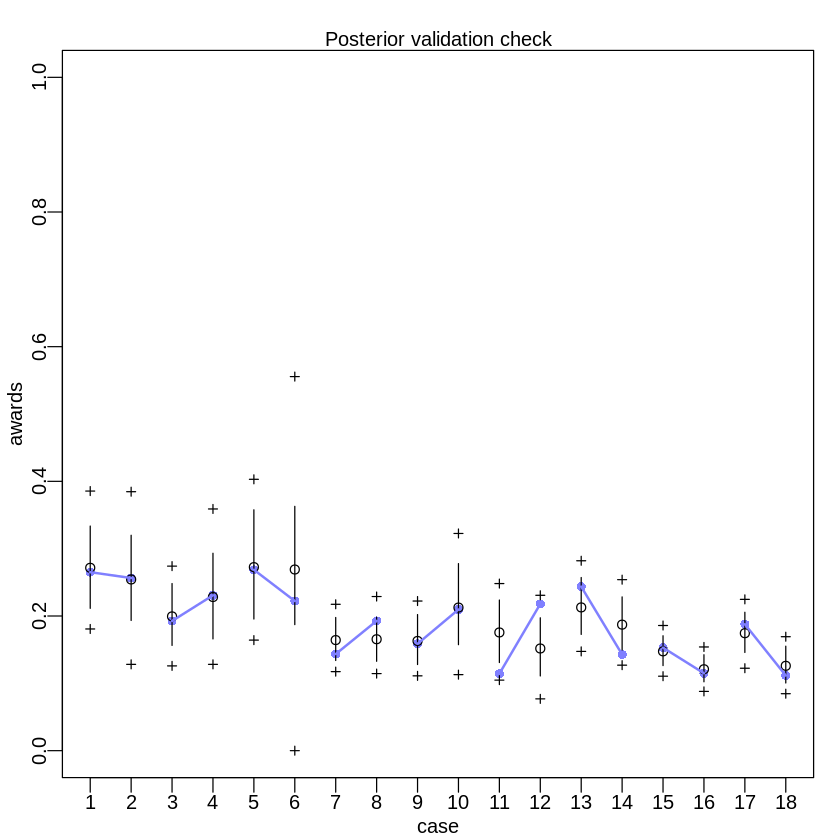

In [195]:
postcheck(m4)
# draw lines connecting points from same discipline
for ( i in 1:9 ) {
x <- 1 + 2*(i-1)
y1 <- d$awards[x]/d$applications[x]
y2 <- d$awards[x+1]/d$applications[x+1]
lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
}

Judging by eye, m5 does the best at predicting the data, better than m3 (which had a lower LOO score) or m4.  For example, m3 doesn't capture the correct trends between males and females in some disciplines, whereas m5 does.

In [197]:
m10 <- quap(
            alist(
                awards ~ dbinom( applications , p ) ,
                logit(p) <- bG[G] + bD[D] + bADG[DG]*applications_std,
                bG[G] ~ dnorm( 0 , 1 ),
                bD[D] ~ dnorm( 0 , 1 ),
                bADG[DG] ~ dnorm( 0 , 0.5 )
#                 bA ~ dnorm( 0 , 1 )
            ) , data=d )

precis(m10, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
bG[1],-1.154258736,0.3227410,-1.6700612,-0.6384563
bG[2],-1.209838065,0.3344766,-1.7443963,-0.6752799
bD[1],0.123942197,0.4250188,-0.5553200,0.8032044
bD[2],-0.232385909,0.3719995,-0.8269130,0.3621412
bD[3],0.100208612,0.4733716,-0.6563306,0.8567478
bD[4],-0.312485629,0.3580983,-0.8847959,0.2598247
bD[5],-0.422216096,0.3690250,-1.0119893,0.1675571
bD[6],-0.512256515,0.3954456,-1.1442550,0.1197419
bD[7],-0.173177736,0.3446180,-0.7239439,0.3775884


In [198]:
compare(m3, m4, m5, m10)

,WAIC,pWAIC,dWAIC,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m3,2517.651,3.073803,0.000000,0.70676526,63.62391,NA
m5,2520.370,13.023110,2.718475,0.18153727,63.75818,6.347609
m4,2521.979,10.433790,4.327619,0.08119790,63.90429,5.654463
m10,2523.937,14.414200,6.285972,0.03049957,63.80705,6.365659


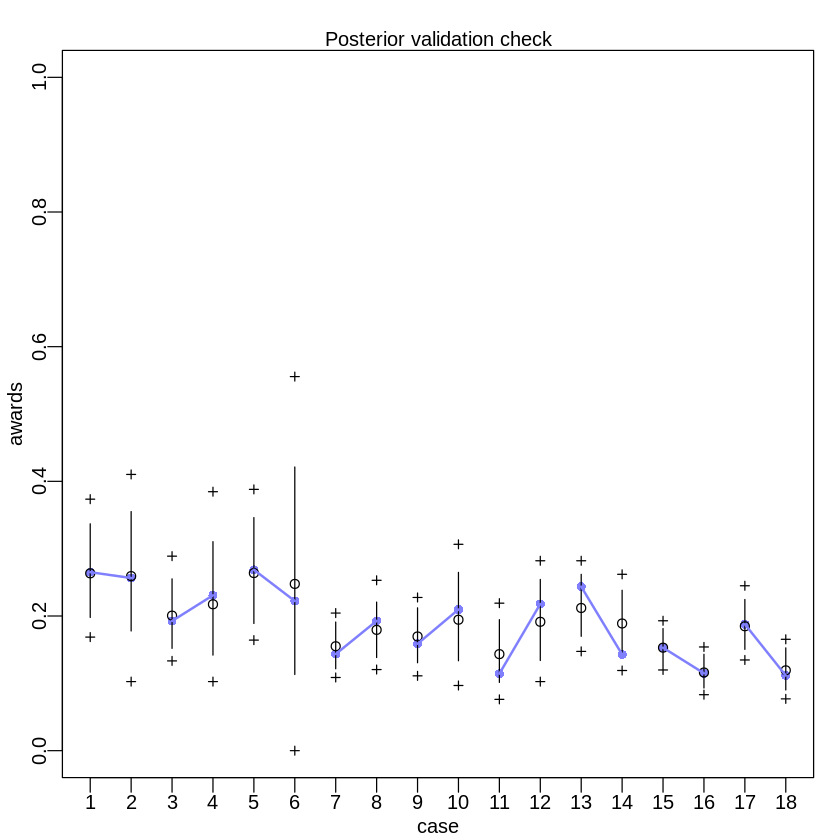

In [202]:
postcheck(m10)
# draw lines connecting points from same discipline
for ( i in 1:9 ) {
x <- 1 + 2*(i-1)
y1 <- d$awards[x]/d$applications[x]
y2 <- d$awards[x+1]/d$applications[x+1]
lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
}

In [204]:
m5b <- quap(
            alist(
                awards ~ dbinom( applications , p ) ,
                logit(p) <- bG[G] + bDG[DG] + bA*applications_std,
                bG[G] ~ dnorm( 0 , 1 ),
#                 bD[D] ~ dnorm( 0 , 1 ),
                bDG[DG] ~ dnorm( 0 , 0.5 ),
                bA ~ dnorm( 0 , 1 )
            ) , data=d )

precis(m5b, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
bG[1],-1.36857550,0.1815460,-1.6587211,-1.07842987
bG[2],-1.49938789,0.1925397,-1.8071035,-1.19167229
bDG[1],0.15862504,0.2820512,-0.2921473,0.60939740
bDG[2],0.12570774,0.3343950,-0.4087200,0.66013550
bDG[3],-0.09178667,0.2542268,-0.4980903,0.31451692
bDG[4],0.03493022,0.3373868,-0.5042791,0.57413956
bDG[5],0.14078781,0.2976103,-0.3348510,0.61642657
bDG[6],-0.01545500,0.4290942,-0.7012304,0.67032039
bDG[7],-0.23597300,0.2382695,-0.6167738,0.14482775


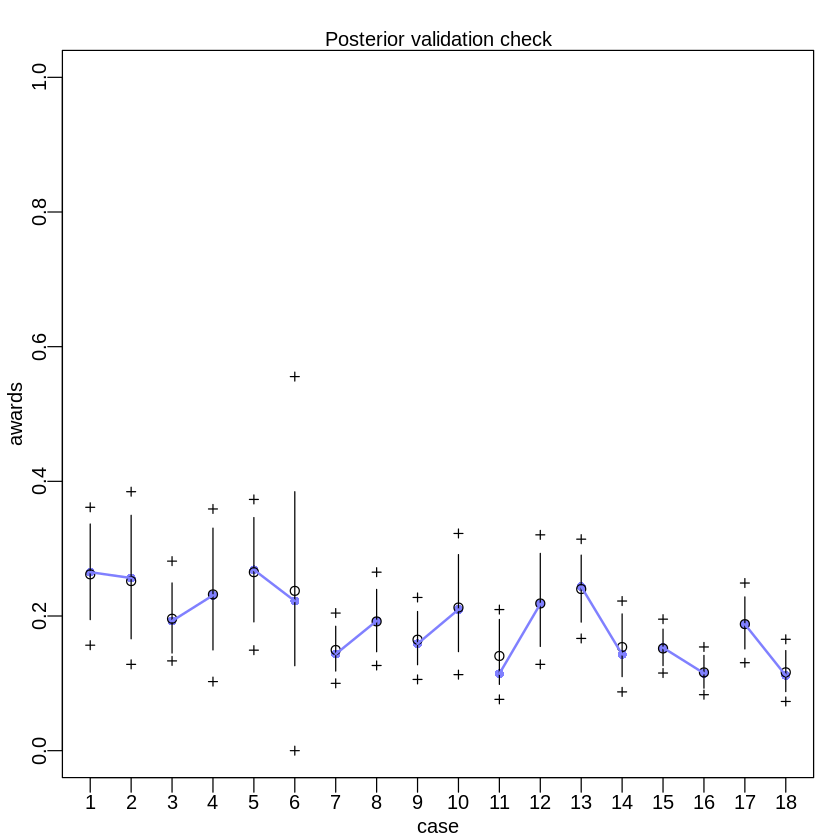

In [206]:
postcheck(m5b)
# draw lines connecting points from same discipline
for ( i in 1:9 ) {
x <- 1 + 2*(i-1)
y1 <- d$awards[x]/d$applications[x]
y2 <- d$awards[x+1]/d$applications[x+1]
lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
}

In [208]:
compare(m3, m4, m5, m5b, m10, func=LOO)

,LOO,pLOO,dLOO,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m3,2517.497,3.00053,0.000000,0.61824194,63.65607,NA
m5,2520.145,12.96208,2.648186,0.16447969,63.89663,6.330049
m5b,2520.462,14.61159,2.965703,0.14033444,63.72423,7.434391
m4,2522.236,10.56144,4.738973,0.05782338,63.89617,5.645793
m10,2524.449,14.58996,6.952233,0.01912055,63.79958,6.227721


m5b does as good a job (by eye, looking at postcheck and also by LOO scores) than m5, despite it being more simple.  It does however have a greater number of effective parameters than m5, despite having fewer actual parameters.

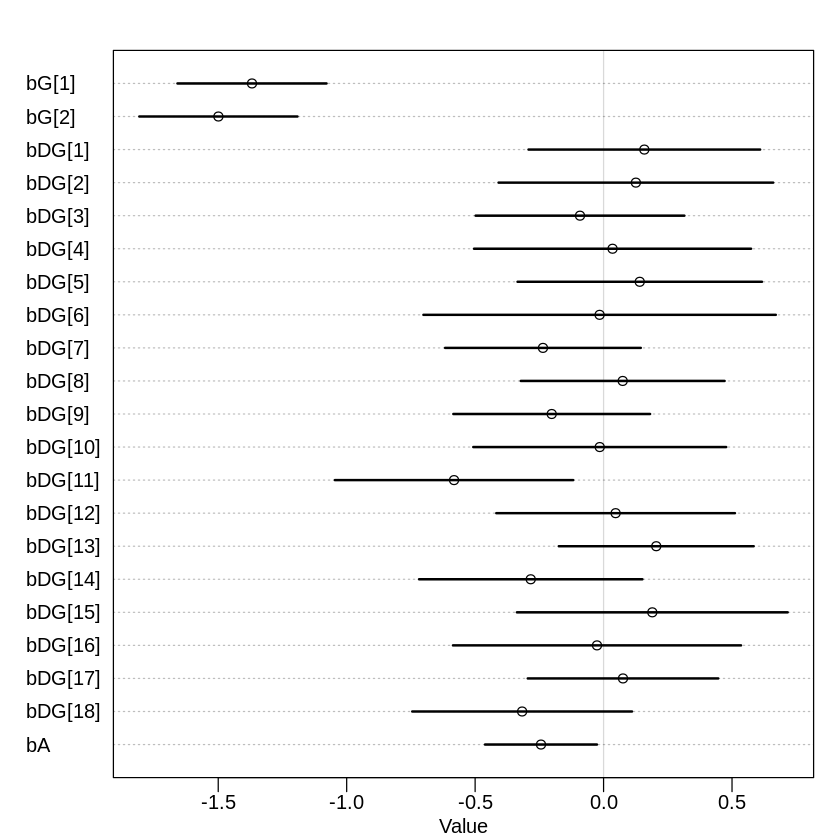

In [209]:
plot(precis(m5b, depth=2))

[1] 0.01970067

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
diff5b,0.01970067,0.04135322,-0.04674946,0.08569899,▁▁▃▇▃▁▁


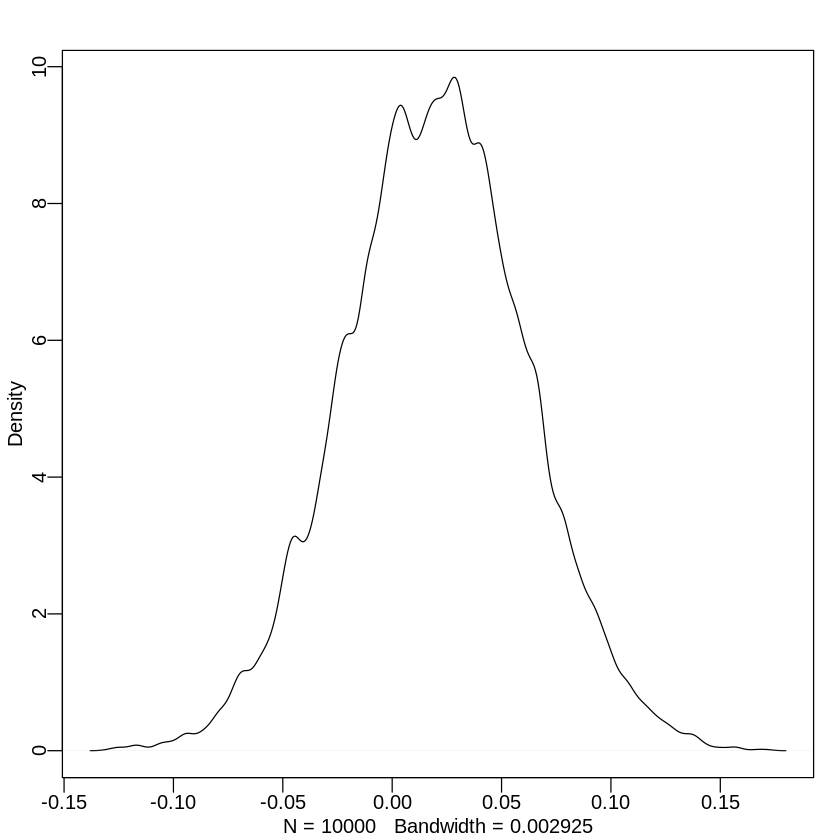

In [210]:
post5b <- extract.samples(m5b)
diff5b <- inv_logit(post5b$bG[,1]) - inv_logit(post5b$bG[,2])
mean(diff5b)
precis(diff5b)
dens(diff5b)

Here, the gender bias appears to not be statistically significant, when we account for the interaction between gender and discipline.

In [212]:
m5c <- quap(
            alist(
                awards ~ dbinom( applications , p ) ,
                logit(p) <- bDG[DG] + bA*applications_std,
                bDG[DG] ~ dnorm( 0 , 0.5 ),
                bA ~ dnorm( 0 , 1 )
            ) , data=d )

precis(m5c, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
bDG[1],-1.0274576,0.2238884,-1.3852745,-0.66964075
bDG[2],-0.9838492,0.2920668,-1.4506283,-0.51706997
bDG[3],-1.2790700,0.1902993,-1.5832051,-0.97493497
bDG[4],-1.0616511,0.2940213,-1.5315540,-0.59174830
bDG[5],-1.0142851,0.2435631,-1.4035461,-0.62502418
bDG[6],-0.5792438,0.4044181,-1.2255820,0.06709433
bDG[7],-1.3597341,0.1815018,-1.6498090,-1.06965915
bDG[8],-1.2219330,0.1751255,-1.5018174,-0.94204872
bDG[9],-1.3581772,0.1774069,-1.6417077,-1.07464665


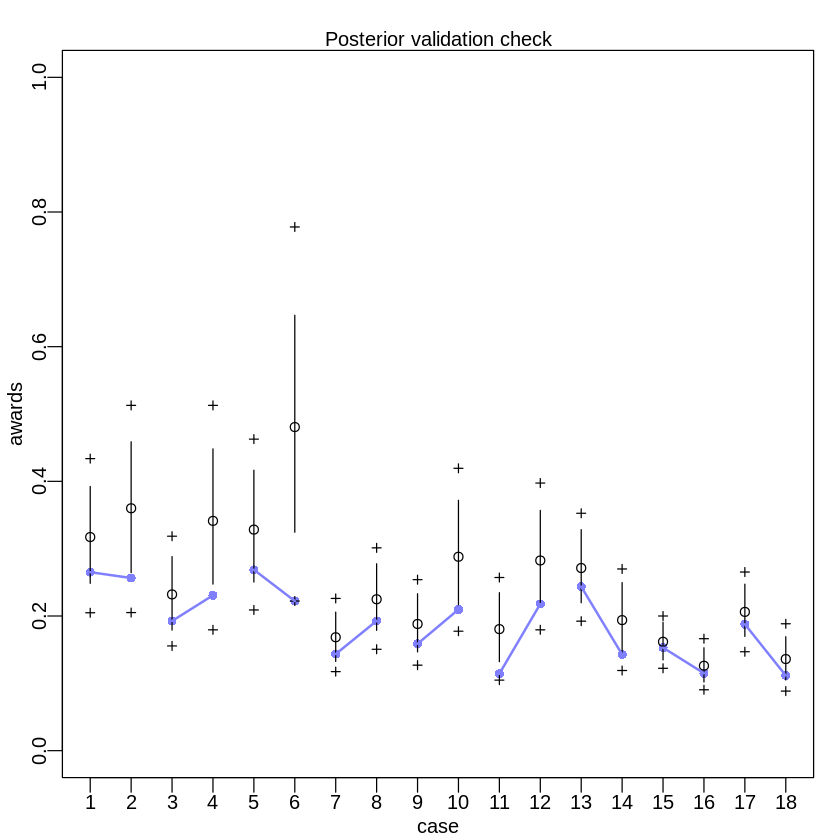

In [213]:
postcheck(m5c)
# draw lines connecting points from same discipline
for ( i in 1:9 ) {
x <- 1 + 2*(i-1)
y1 <- d$awards[x]/d$applications[x]
y2 <- d$awards[x+1]/d$applications[x+1]
lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
}

In [214]:
compare(m5, m5b, m5c)

,WAIC,pWAIC,dWAIC,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m5b,2520.305,14.55297,0.0000000,5.196100e-01,63.77600,NA
m5,2520.462,13.00617,0.1569857,4.803840e-01,63.83927,2.875266
m5c,2543.027,13.07968,22.7220198,6.048582e-06,57.09649,9.350392


Clearly, removing the main effect of gender reduces the ability of the model to fit the data.

AUTHOR's ANSWER

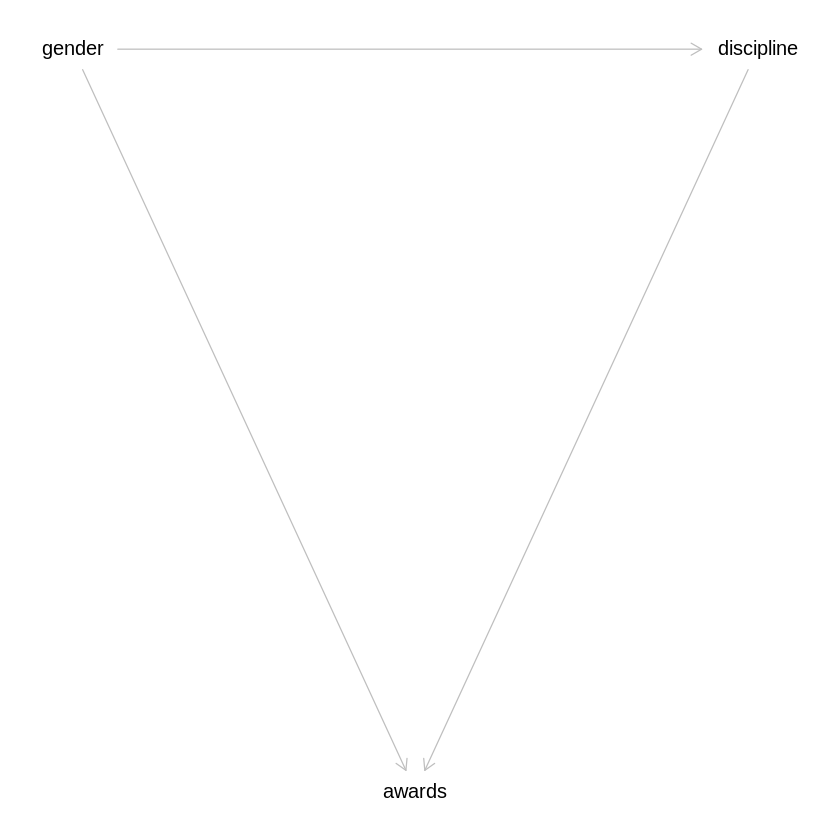

In [240]:
grants_dag <- dagitty(
                    "dag {
                            gender -> discipline -> awards
                            gender -> awards
                        }"
                    )

coordinates( grants_dag ) <- list( x=c(gender=0,discipline=1,awards=0.5) , y=c(gender=0,discipline=0,awards=1) ) 

plot( grants_dag )

In [217]:
dat_list <- list(
    awards = as.integer(d$awards),
    apps = as.integer(d$applications),
    gid = ifelse( d$gender=="m" , 1L , 2L )
)

m1_total <- ulam(
                alist(
                    awards ~ binomial( apps , p ),
                    logit(p) <- a[gid],
                    a[gid] ~ normal(-1,1)
                ), data=dat_list , chains=4, cores=4 )

precis(m1_total,depth=2)

recompiling to avoid crashing R session


,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a[1],-1.535028,0.06679639,-1.640579,-1.428422,1147.085,1.003476
a[2],-1.738395,0.08040181,-1.868961,-1.612345,1238.303,1.002927


In [235]:
dat_list$disc <- as.integer(d$discipline)
d$dat_list$disc <- as.integer(d$discipline)
#dat_list$disc <- rep(1:9, each=2)

m1_direct <- ulam(
                alist(
                    awards ~ dbinom( apps , p ),
                    logit(p) <- a[gid] + d[disc],
                    a[gid] ~ dnorm(-1,1),
                    d[disc] ~ dnorm(0,1)
                ),
                data=dat_list 
                , chains=4 , cores=4 , iter=3000 
            )

precis(m1_direct,depth=2)

recompiling to avoid crashing R session


,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a[1],-1.3426190343,0.3016228,-1.8238443,-0.86273472,595.5799,1.003978
a[2],-1.4812499226,0.3065202,-1.9723153,-0.98549497,600.6055,1.004307
d[1],0.3315197881,0.3471413,-0.2216573,0.88154823,805.5901,1.002966
d[2],0.0007012281,0.3303094,-0.5313423,0.52034404,675.6882,1.003533
d[3],-0.2308039824,0.3200423,-0.7406034,0.27913052,676.9685,1.003403
d[4],-0.2716444633,0.3462774,-0.8248047,0.28450308,868.1398,1.003046
d[5],-0.3345621018,0.3179032,-0.8529351,0.17001255,640.2920,1.003739
d[6],-0.0157045670,0.3408277,-0.5625506,0.52607104,781.7773,1.004060
d[7],0.2883963930,0.3836327,-0.3256470,0.89829895,1003.4715,1.003321


In [239]:
post <- extract.samples(m1_direct)
diff_a <- post$a[,1] - post$a[,2]
precis( list( diff_a=diff_a ) )

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
diff_a,0.1386309,0.1087487,-0.03328486,0.3126036,▁▁▂▅▇▅▁▁▁


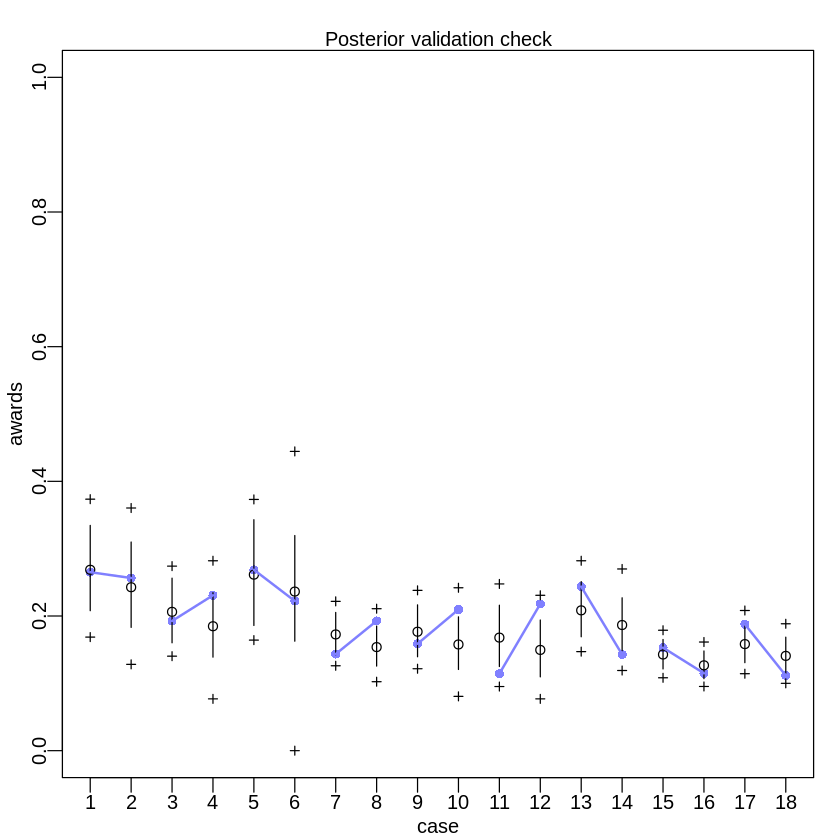

In [251]:
postcheck(m1_direct)
# draw lines connecting points from same discipline
for ( i in 1:9 ) {
x <- 1 + 2*(i-1)
y1 <- d$awards[x]/d$applications[x]
y2 <- d$awards[x+1]/d$applications[x+1]
lines( c(x,x+1) , c(y1,y2) , col=rangi2 , lwd=2 )
text( x+0.5 , (y1+y2)/2 + 0.05 , d$dept[x] , cex=0.8 , col=rangi2 )
}

Note that this formulation gets the difference between males and females incorrect in many disciplines.

QUESTION 2

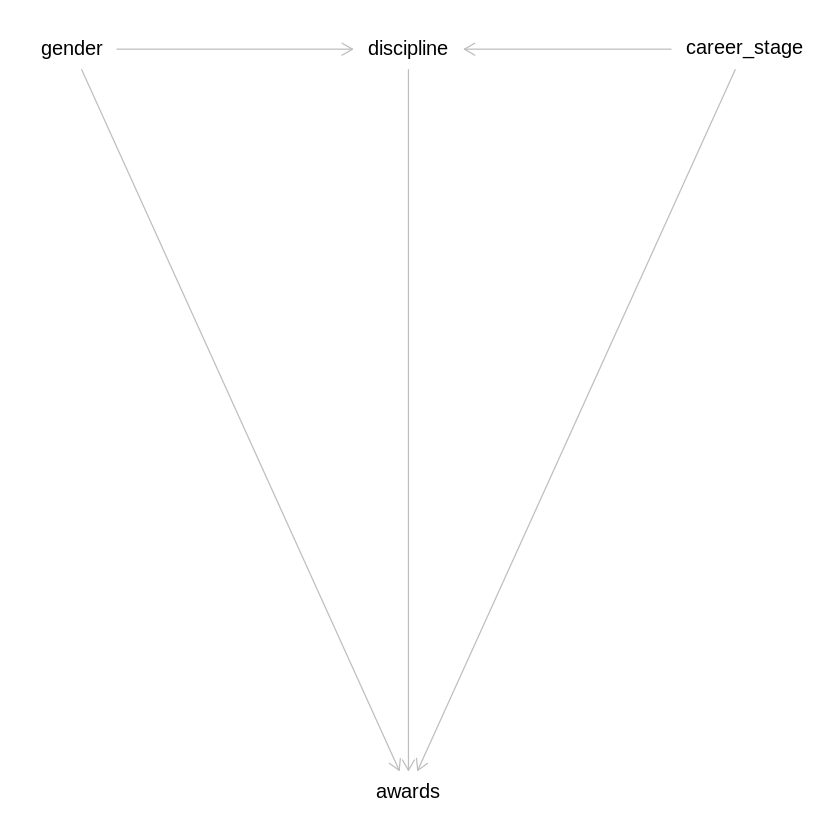

In [249]:
grants_dag2 <- dagitty(
                    "dag {
                            gender -> discipline -> awards
                            career_stage -> awards
                            gender -> awards
                            career_stage -> discipline
                        }"
                    )

coordinates( grants_dag2 ) <- list( x=c(gender=0,discipline=0.5,career_stage=1,awards=0.5) , y=c(gender=0,discipline=0,career_stage=0,awards=1) ) 

plot( grants_dag2 )

Because discipline is now a collider with the unobserved confound (let's use career stage as the author suggests), conditioning on it will open the back-door path between gender and career stage, and from career stage to awards, so there is a back-door from gender to awards via career stage.  Of course, we don't have data on the career stage, or whatever unobserved confound it is, so we only have a confounded estimate of the influence of gender on awards.

In [252]:
set.seed(1913)
N <- 1000
G <- rbern(N)
S <- rbern(N)
D <- rbern( N , p=inv_logit( G + S ) )
A <- rbern( N , p=inv_logit( 0.25*G + D + 2*S - 2 ) )
dat_sim <- list( G=G , D=D , A=A )

In [254]:
m2_sim <- ulam(
            alist(
                A ~ bernoulli(p),
                logit(p) <- a + d*D + g*G,
                c(a,d,g) ~ normal(0,1)
            ), data=dat_sim , chains=4 , cores=4 )

precis(m2_sim)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
g,0.3457812,0.1348350,0.1233885,0.5652757,911.9982,1.001753
d,1.2134305,0.1531279,0.9657106,1.4600484,900.2982,1.001490
a,-1.0726690,0.1413817,-1.2971733,-0.8518971,876.6163,1.002950


In [255]:
set.seed(1913)
N <- 1000
G <- rbern(N)
S <- rbern(N)
D <- rbern( N , p=inv_logit( 2*G - S ) )
A <- rbern( N , p=inv_logit( 0*G + D + S - 2 ) )
dat_sim2 <- list( G=G , D=D , A=A )

m2_sim_2 <- ulam( m2_sim , data=dat_sim2 , chains=4 , cores=4 )

precis(m2_sim_2,2)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
g,0.2419072,0.1548608,-0.01533415,0.4892338,1136.7356,0.9991764
d,0.2818902,0.1528582,0.03978933,0.5301607,1052.4260,1.0021543
a,-1.1252949,0.1154198,-1.31010111,-0.9448658,976.5944,1.0021226


QUESTION 3

In [2]:
data(Primates301)
d <- Primates301

In [3]:
head(d)

name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NA,1,1,0,6,58.02,4655.00,40.0,NA,106.15,276.0,NA,NA
Allocebus_trichotis,Allocebus,trichotis,NA,2,2,0,6,NA,78.09,1.0,NA,NA,NA,NA,NA
Alouatta_belzebul,Alouatta,belzebul,NA,3,3,0,15,52.84,6395.00,7.4,NA,NA,NA,NA,NA
Alouatta_caraya,Alouatta,caraya,NA,4,3,0,45,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
Alouatta_guariba,Alouatta,guariba,NA,5,3,0,37,51.70,5175.00,7.4,NA,NA,NA,NA,NA
Alouatta_palliata,Alouatta,palliata,NA,6,3,3,79,49.88,6250.00,13.1,185.42,495.60,300.0,1578.42,681.02


In [4]:
dat <- data.frame(name=d$name, social_learning=d$social_learning, brain=d$brain)
dat  <- dat[complete.cases(dat),]
dat_slim <- list(social_learning=dat$social_learning, brain=dat$brain)
min(dat$social_learning)
max(dat$social_learning)
log(min(dat$brain))
log(max(dat$brain))

[1] 0

[1] 214

[1] 0.48858

[1] 6.195242

So lambda needs to range from 0 to ~ 200, while log(brain) ranges from 0 to ~ 6.  If we assume a positive relationship between brain size and social learning, this means that lambda should be around 200 for log(brain) ~ 6, while lambda should be around 0 for log(brain) ~ 0.

We sample the prior possibilities below:

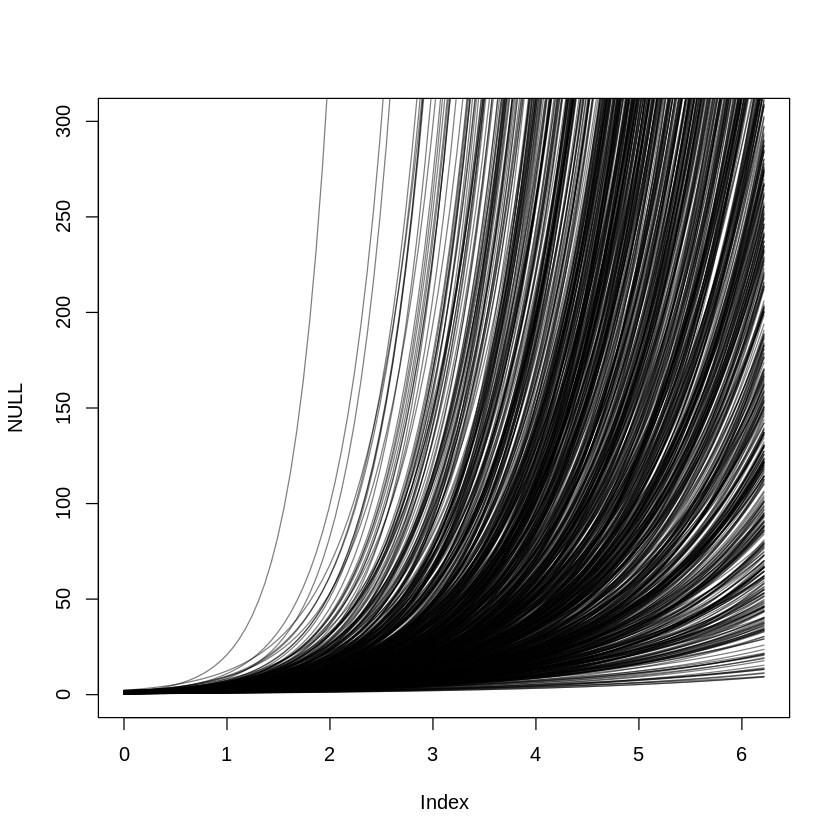

In [6]:
N <- 1e3
a <- rnorm( N , 0 , 0.3 )
b <- rlnorm( N , 0 , 0.3 )
plot( NULL , xlim=c(log(1),log(500)) , ylim=c(0,300) )
for ( i in 1:N ) curve( exp( a[i] + b[i]*x ) , add=TRUE , col=col.alpha("black",0.5) )

In [13]:
m_primate <- ulam(
                    alist(
                        social_learning ~ dpois(lambda),
                        log(lambda) <- a + bB * log(brain),
                        a ~ dnorm(0, 0.3),
                        bB ~ dlnorm(0, 0.3)
                    ), data=dat_slim, chains=4, cores=4, log_lik=TRUE
                    , control=list(max_treedepth=15
                                  )
                )

In [7]:
precis(m_primate)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,-4.804236,0.19652560,-5.119456,-4.490447,445.9981,1.007213
bB,1.390745,0.04019048,1.325520,1.457143,446.2088,1.008730


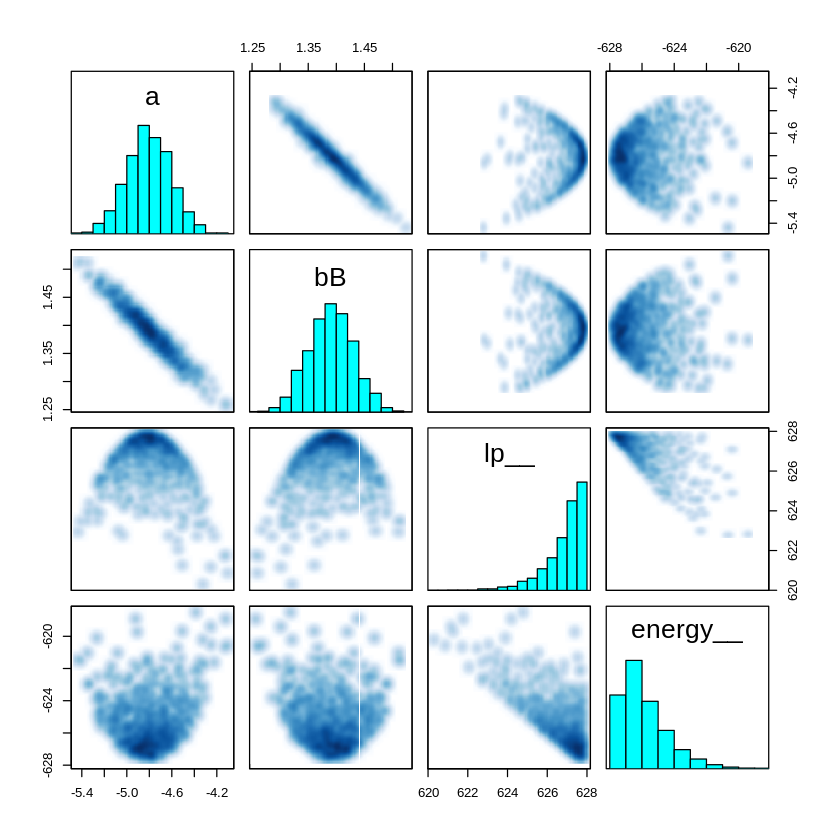

In [8]:
pairs(m_primate@stanfit)

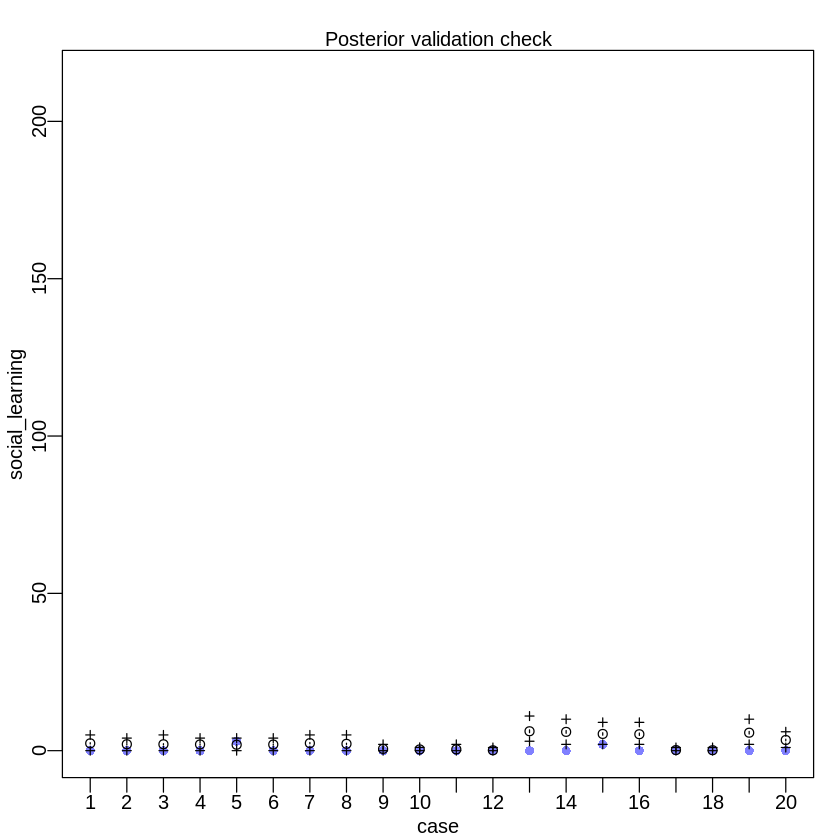

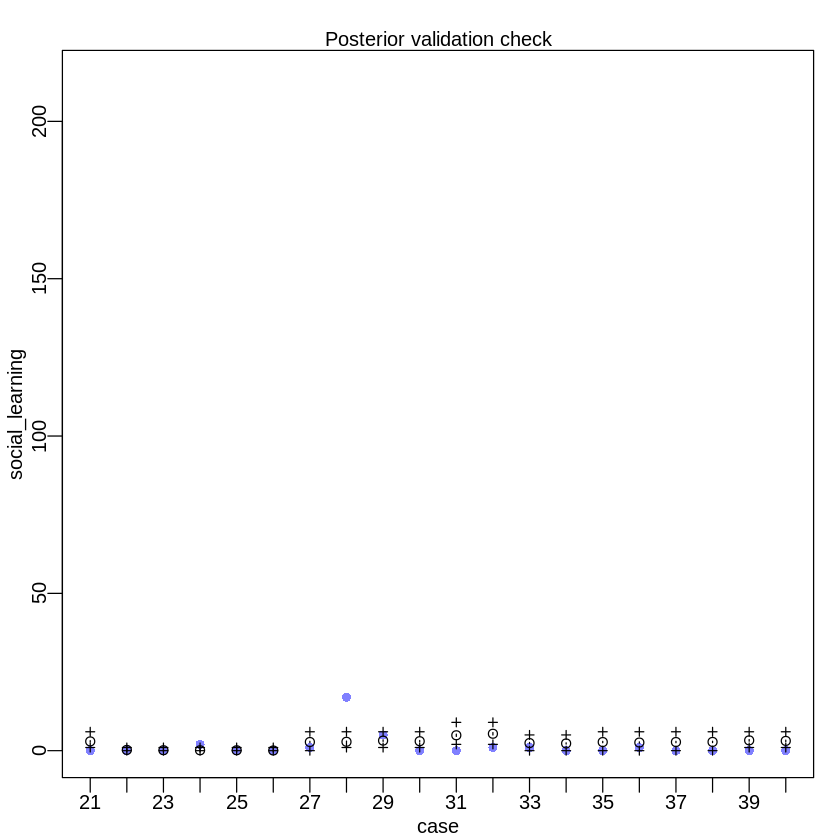

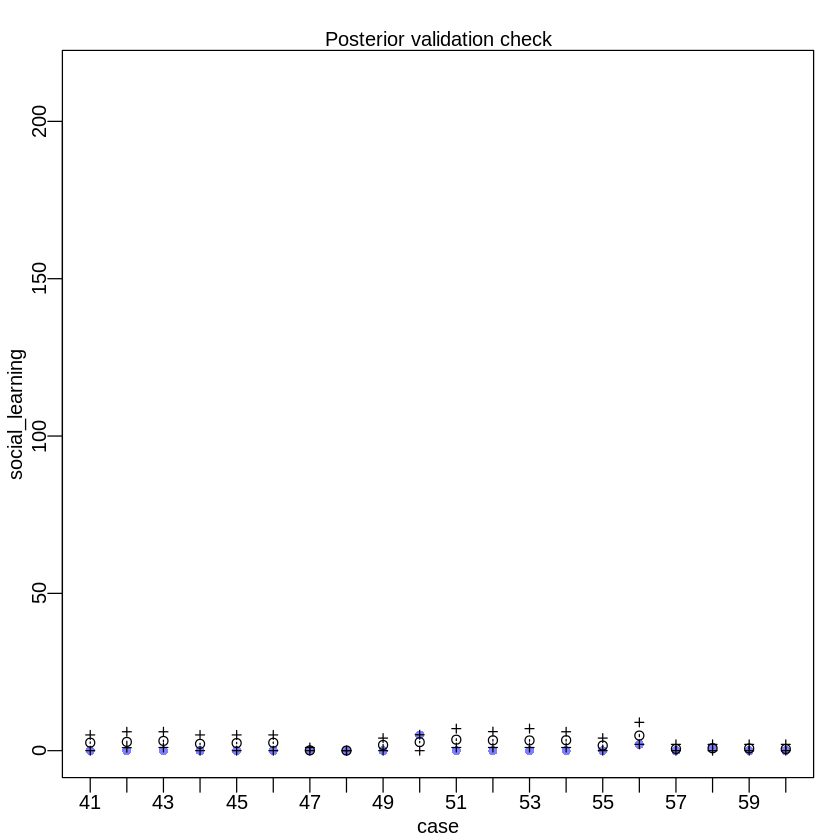

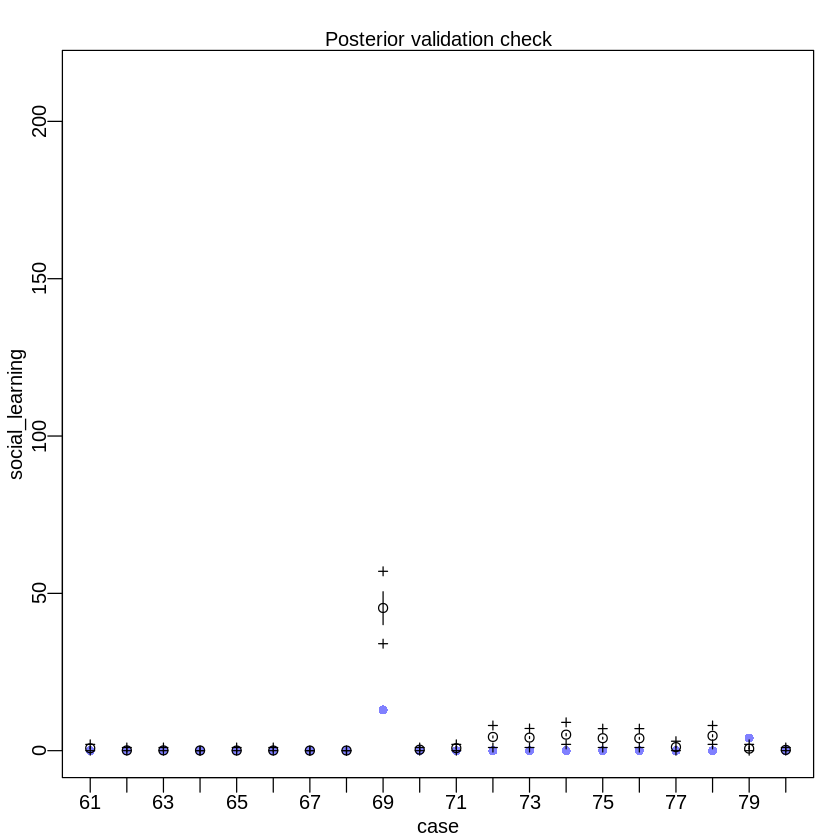

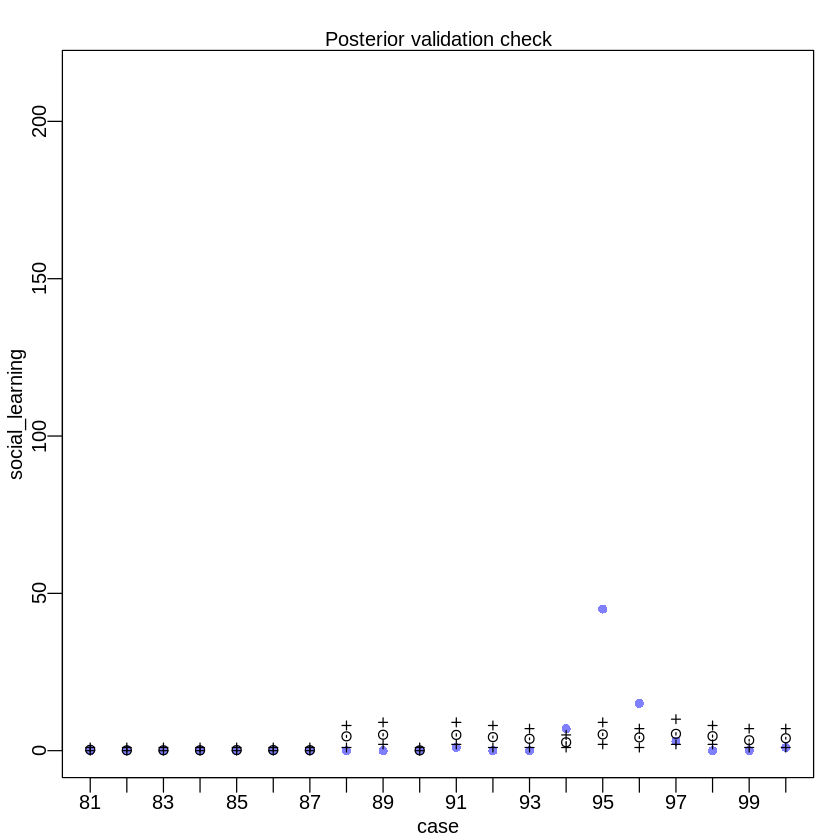

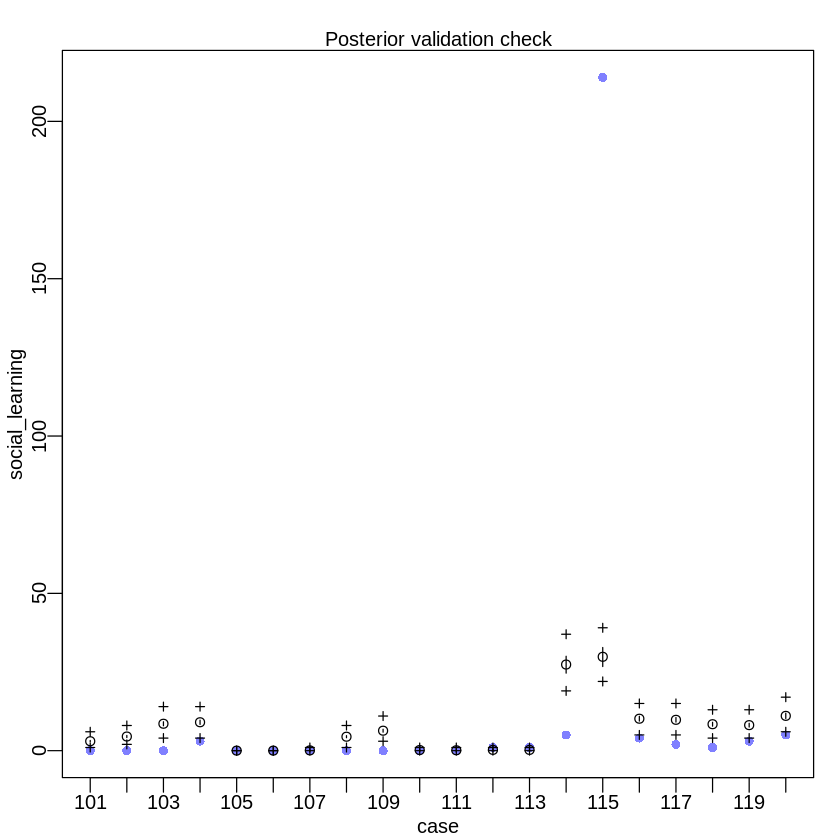

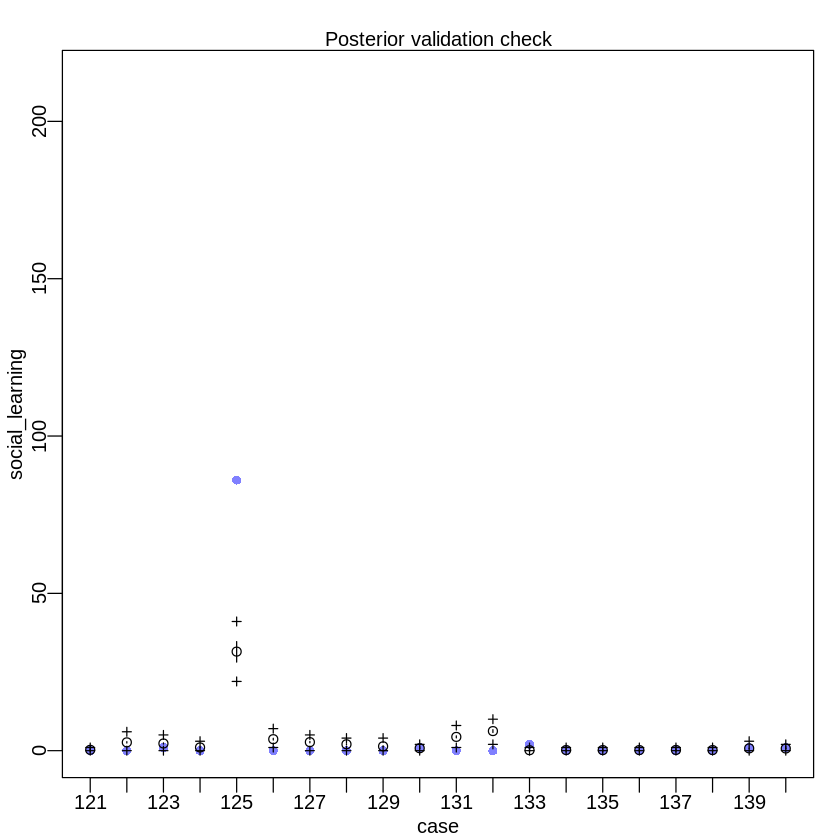

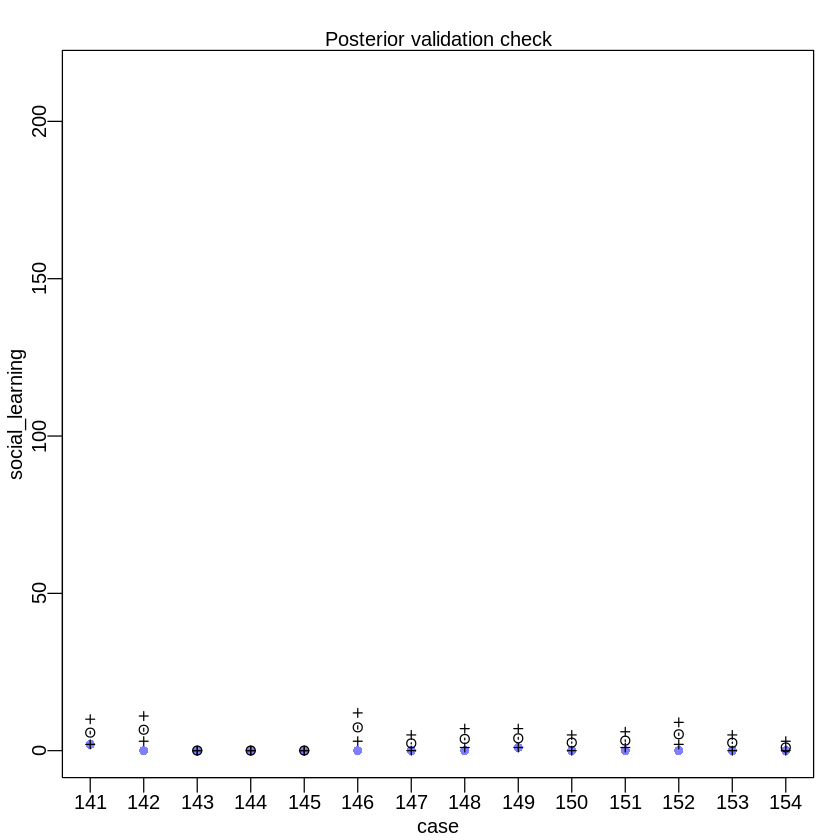

In [9]:
postcheck(m_primate)

In [37]:
m_primateQ <- quap(
                    alist(
                        social_learning ~ dpois(lambda),
                        log(lambda) <- a + bB * log(brain),
                        a ~ dnorm(0, 0.3),
                        bB ~ dlnorm(0, 0.3)
                    ), data=dat_slim
                )

precis(m_primateQ)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-4.808680,0.20054283,-5.129186,-4.488174
bB,1.392057,0.04114366,1.326301,1.457812


The estimates are very sensitive to the priors.  A looser prior causes the magnitude of the coefficients to increase.  How to determine an appropriate prior (other than by simulatiing as above?).  Shall we check the WAIC / LOO scores?

In [12]:
compare(m_primate, m_primateQ)

Warning message in compare(m_primate, m_primateQ):
“Not all model fits of same class.
This is usually a bad idea, because it implies they were fit by different algorithms.
Check yourself, before you wreck yourself.”

ERROR: Error in check_pars(allpars, pars): no parameter log_lik


In [14]:
m_primate0.1 <- ulam(
                    alist(
                        social_learning ~ dpois(lambda),
                        log(lambda) <- a + bB * log(brain),
                        a ~ dnorm(0, 0.1),
                        bB ~ dlnorm(0, 0.1)
                    ), data=dat_slim, chains=4, cores=4, log_lik=TRUE
                    , control=list(max_treedepth=15
                                  )
                )

m_primate0.5 <- ulam(
                    alist(
                        social_learning ~ dpois(lambda),
                        log(lambda) <- a + bB * log(brain),
                        a ~ dnorm(0, 0.5),
                        bB ~ dlnorm(0, 0.5)
                    ), data=dat_slim, chains=4, cores=4, log_lik=TRUE
                    , control=list(max_treedepth=15
                                  )
                )

m_primate1 <- ulam(
                    alist(
                        social_learning ~ dpois(lambda),
                        log(lambda) <- a + bB * log(brain),
                        a ~ dnorm(0, 1),
                        bB ~ dlnorm(0, 1)
                    ), data=dat_slim, chains=4, cores=4, log_lik=TRUE
                    , control=list(max_treedepth=15
                                  )
                )

compare(m_primate0.1, m_primate, m_primate0.5, m_primate1, func=LOO)

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”Warning message in log(z):
“NaNs produced”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”Warning message in log(z):
“NaNs produced”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”Warning message in log(z):
“NaNs produced”

,LOO,pLOO,dLOO,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m_primate1,1345.149,94.88090,0.00000,1.000000e+00,420.8374,NA
m_primate0.5,1400.323,87.89302,55.17415,1.044926e-12,454.2289,91.67558
m_primate,1586.609,96.74407,241.45943,3.696158e-53,573.1768,242.25732
m_primate0.1,2134.258,76.77594,789.10920,4.437259e-172,868.2950,546.57680


Unsurprisingly, the model with the flattest priors (and greatest effective parameters) has the best LOO score.  There are some pareto k diagnostic warnings though.

In [28]:
k <- LOOPk(m_primate)

print(dat$name[which(k>1)])
(k[k>1])

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”Warning message in log(z):
“NaNs produced”

[1] Gorilla_gorilla_gorilla     Pan_troglodytes_troglodytes
[3] Pongo_pygmaeus             
301 Levels: Allenopithecus_nigroviridis ... Varecia_variegata_variegata


[1] 1.076624 5.165563 1.741765

The interpretation is that:

log(lambda) = a + b * log(Brain)
lambda = exp(a) * (Brain ^ b)

so if brain size doubles, the expected amount of social learning (lambda) should increase by a factor of 2^b.

Also,

d(lambda) / lambda = b * d(Brain) / Brain

So a 1% increase in the brain size corresponds to a b% increase in social learning.

In [43]:
m_primate2 <- ulam(
                    alist(
                        social_learning ~ dpois(lambda),
                        log(lambda) <- a + bB * log(brain),
                        a ~ dnorm(0, 2),
                        bB ~ dlnorm(0, 2)
                    ), data=dat_slim, chains=4, cores=4, log_lik=TRUE
                    , control=list(max_treedepth=15
                                  )
                )

In [47]:
precis(m_primate2)

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,-9.423004,0.33472208,-9.938752,-8.859762,259.8436,1.008656
bB,2.270143,0.06172191,2.165988,2.364551,256.0123,1.008880


In [54]:
m_primate5q <- quap(
                    alist(
                        social_learning ~ dpois(lambda),
                        log(lambda) <- a + bB * log(brain),
                        a ~ dnorm(0, 5),
                        bB ~ dlnorm(0, 5)
                    ), data=dat_slim
                )

precis(m_primate5q)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-9.679466,0.34431429,-10.229747,-9.129186
bB,2.317193,0.06293108,2.216617,2.417769


In [67]:
compare(m_primate0.1, m_primate, m_primate0.5, m_primate1, m_primate2, m_primate5q, func=LOO)

Warning message in compare(m_primate0.1, m_primate, m_primate0.5, m_primate1, m_primate2, :
“Not all model fits of same class.
This is usually a bad idea, because it implies they were fit by different algorithms.
Check yourself, before you wreck yourself.”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”Warning message in log(z):
“NaNs produced”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”Warning message in log(z):
“NaNs produced”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”Warning message in log(z):
“NaNs produced”Warning me

,LOO,pLOO,dLOO,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m_primate5q,1333.483,92.90330,0.000000,9.197664e-01,411.7352,NA
m_primate2,1338.430,92.66047,4.946683,7.753880e-02,419.4751,24.45301
m_primate1,1345.149,94.88090,11.665597,2.694793e-03,420.8374,47.28000
m_primate0.5,1400.323,87.89302,66.839747,2.815859e-15,454.2289,138.85669
m_primate,1586.609,96.74407,253.125029,9.960379e-56,573.1768,288.13889
m_primate0.1,2134.258,76.77594,800.774795,1.195750e-174,868.2950,589.02876


In [87]:
coeftab(m_primate0.1, m_primate, m_primate0.5, m_primate1, m_primate2, m_primate5q)

     m_primate0.1 m_primate m_primate0.5 m_primate1 m_primate2 m_primate5q
a      -1.29        -4.80     -6.89        -8.75      -9.42      -9.68    
bB      0.66         1.39      1.80         2.15       2.27       2.32    
nobs     154          154       154          154        154        154    

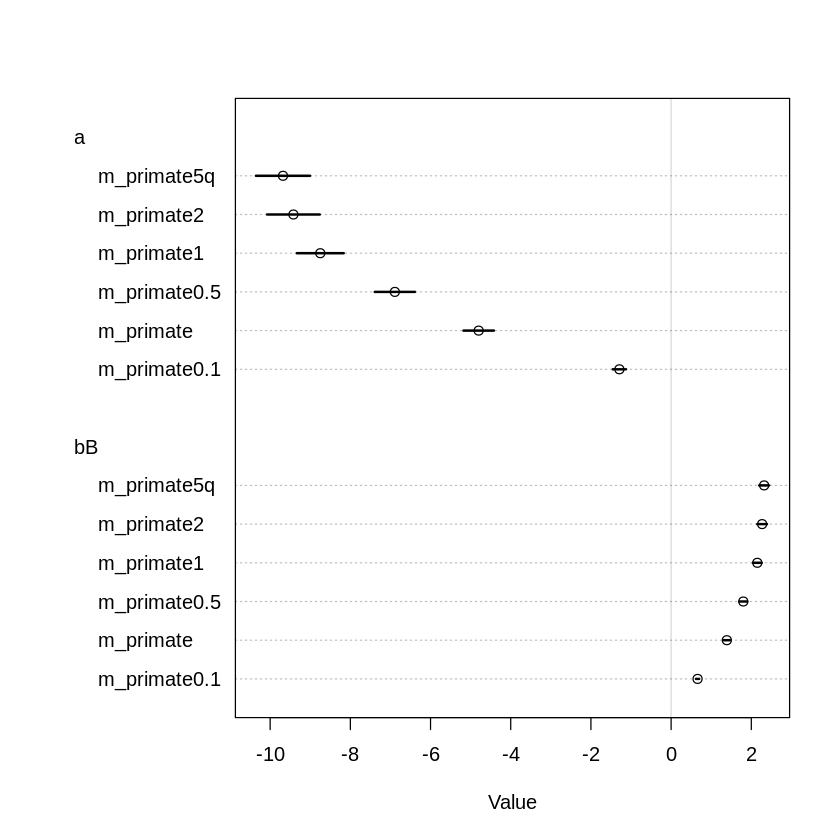

In [55]:
plot(coeftab(m_primate0.1, m_primate, m_primate0.5, m_primate1, m_primate2, m_primate5q))

So if we really use flat priors, the bB coefficient seems to converge to just over 2.3.  So a 1% increase in brain size seems to lead to a 2.3% increase in social learning.

In [64]:
datRE <- data.frame(name=d$name, social_learning=d$social_learning, brain=d$brain, research_effort=d$research_effort)
datRE  <- datRE[complete.cases(datRE),]
dat_slimRE <- list(social_learning=datRE$social_learning, brain=datRE$brain, research_effort=datRE$research_effort)

min(datRE$social_learning)
max(datRE$social_learning)
log(min(datRE$brain))
log(max(datRE$brain))
log(min(datRE$research_effort))
log(max(datRE$research_effort))

dat_slimRE

[1] 0

[1] 214

[1] 0.48858

[1] 6.195242

[1] 0

[1] 6.626718

$social_learning
  [1]   0   0   0   0   3   0   0   0   0   0   0   0   0   0   2   0   0   0
 [19]   0   0   0   0   0   2   0   1  17   5   0   0   1   1   0   0   1   0
 [37]   0   0   0   0   0   0   0   0   0   0   0   0   5   0   0   0   0   0
 [55]   2   0   1   0   0   0   0   0   0   0   0  13   0   0   0   0   0   0
 [73]   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   1   0   0
 [91]   7  45  15   3   0   0   1   0   0   0   3   0   0   0   0   0   0   0
[109]   1   1   5 214   4   2   1   3   5   0   0   1   0  86   0   0   0   0
[127]   1   0   0   2   0   0   0   0   1   1   2   0   0   0   0   0   0   0
[145]   1   0   0   0   0   0

$brain
  [1]  58.02  52.84  52.63  51.70  49.88  51.13  59.08  55.22  20.67  16.30
 [11]  16.85   6.92 117.02 114.24 105.09 103.85   9.86   7.95 110.68  76.00
 [21]  68.77  11.43   7.95   7.24   4.17  65.45  66.63  72.93  69.84  99.07
 [31] 105.99  59.58  57.39  65.26  62.61  65.40  65.90  74.20  71.33  61.84
 [41]  65.97  71.13  55.08  59.56  61.45   5.81   2.60  48.33  65.00  77.70
 [51]  74.39  73.83  74.90  44.85  97.73  20.65  25.77  24.51  20.17  26.23
 [61]   5.53   5.58   3.71   3.96   2.65 490.41  14.09  27.14  91.16  87.99
 [71] 101.87  85.13  84.69  34.81  96.50  22.90  11.84  12.83   6.70   7.25
 [81]   6.87   9.75   9.56   8.25  93.97 101.59   5.87 100.70  90.46  82.00
 [91]  63.98 102.92  88.98 105.59  94.90  74.87  85.00  69.70  93.20 148.00
[101] 153.88   1.63   1.72   5.80  92.30 119.38  10.13   7.23  11.78  11.50
[111] 341.29 363.05 167.42 163.19 146.17 142.50 178.00  12.42  63.59  57.25
[121]  32.26 377.38  80.30  64.85  52.60  39.80  26.21  91.41 117.76   7.94
[131]   9.70   9.78  11.09   9.76  25.07  24.14 110.93 123.50   3.16   3.00
[141]   3.36 133.33  57.86  81.30  84.60  62.12  72.84 103.64  61.29  32.12

$research_effort
  [1]   6  15  45  37  79  25   4  82  22  16  58   1  12   4  58  30  10   6
 [19]  24  11   8  43  16 161  36  13 249  60  18  19  32  26  11   8  28   3
 [37]   4   7  56   8  17   7   5   8   7   3  13  21  91  16  42  17  10  52
 [55]  33  11  81  32  13  13   1   2  14  20   5 517  40   8  16   4  86   5
 [73]  16   8  34 103  46  85   1   5   2   1   5   2  34   6  14  48  17  12
 [91] 174 253 296  51  27  34  48  12  67  18  30  66   8   3  17   4  37  19
[109]  36  12 225 755  43 114  78   8  22  10  52   7  28 321  11   6   3  28
[127]  41  25  36  81   3  17  46 153   4  89  98  40   8   2  10  34   8   7
[145]   9   6  16   5   2  57

So log research effort has a similar scale to log brain size.

In [65]:
m_primate0.1RE <- ulam(
                    alist(
                        social_learning ~ dpois(lambda),
                        log(lambda) <- a + bB * log(brain) + bR * log(research_effort),
                        a ~ dnorm(0, 0.1),
                        bB ~ dlnorm(0, 0.1),
                        bR ~ dlnorm(0, 0.1)
                    ), data=dat_slimRE, chains=4, cores=4, log_lik=TRUE
                    , control=list(max_treedepth=15
                                  )
                )

m_primate0.3RE <- ulam(
                    alist(
                        social_learning ~ dpois(lambda),
                        log(lambda) <- a + bB * log(brain) + bR * log(research_effort),
                        a ~ dnorm(0, 0.3),
                        bB ~ dlnorm(0, 0.3),
                        bR ~ dlnorm(0, 0.3)
                    ), data=dat_slimRE, chains=4, cores=4, log_lik=TRUE
                    , control=list(max_treedepth=15
                                  )
                )

m_primate0.5RE <- ulam(
                    alist(
                        social_learning ~ dpois(lambda),
                        log(lambda) <- a + bB * log(brain) + bR * log(research_effort),
                        a ~ dnorm(0, 0.5),
                        bB ~ dlnorm(0, 0.5),
                        bR ~ dlnorm(0, 0.5)
                    ), data=dat_slimRE, chains=4, cores=4, log_lik=TRUE
                    , control=list(max_treedepth=15
                                  )
                )

m_primate1RE <- ulam(
                    alist(
                        social_learning ~ dpois(lambda),
                        log(lambda) <- a + bB * log(brain) + bR * log(research_effort),
                        a ~ dnorm(0, 1),
                        bB ~ dlnorm(0, 1),
                        bR ~ dlnorm(0, 1)
                    ), data=dat_slimRE, chains=4, cores=4, log_lik=TRUE
                    , control=list(max_treedepth=15
                                  )
                )

m_primate2RE <- ulam(
                    alist(
                        social_learning ~ dpois(lambda),
                        log(lambda) <- a + bB * log(brain) + bR * log(research_effort),
                        a ~ dnorm(0, 2),
                        bB ~ dlnorm(0, 2),
                        bR ~ dlnorm(0, 2)
                    ), data=dat_slimRE, chains=4, cores=4, log_lik=TRUE
                    , control=list(max_treedepth=15
                                  )
                )

m_primate5RE <- ulam(
                    alist(
                        social_learning ~ dpois(lambda),
                        log(lambda) <- a + bB * log(brain) + bR * log(research_effort),
                        a ~ dnorm(0, 5),
                        bB ~ dlnorm(0, 5),
                        bR ~ dlnorm(0, 5)
                    ), data=dat_slimRE, chains=4, cores=4, log_lik=TRUE
                    , control=list(max_treedepth=15
                                  )
                )

compare(m_primate0.1RE, m_primate0.3RE, m_primate0.5RE, m_primate1RE, m_primate2RE, m_primate5RE, func=LOO)

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”Warning message in log(z):
“NaNs produced”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”Warning message in log(z):
“NaNs produced”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”Warning message in log(z):
“NaNs produced”Warning message in log(z):
“NaNs produced”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”Warning message in log(z):
“NaNs produced”Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
”Warning message in log(z):
“NaNs produced”Warning message in log(z):
“Na

,LOO,pLOO,dLOO,weight,SE,dSE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m_primate5RE,544.3933,44.01886,0.0000000,4.779580e-01,158.6441,NA
m_primate2RE,544.7397,44.29591,0.3464171,4.019446e-01,156.1729,4.909328
m_primate1RE,547.1558,43.08293,2.7624393,1.200974e-01,153.8159,12.165130
m_primate0.5RE,590.0228,48.67978,45.6294796,5.903018e-11,153.4552,46.556112
m_primate0.3RE,684.3310,50.54670,139.9376588,1.960258e-31,162.7819,99.483640
m_primate0.1RE,1316.1697,75.77667,771.7764104,1.231038e-168,371.2083,346.905498


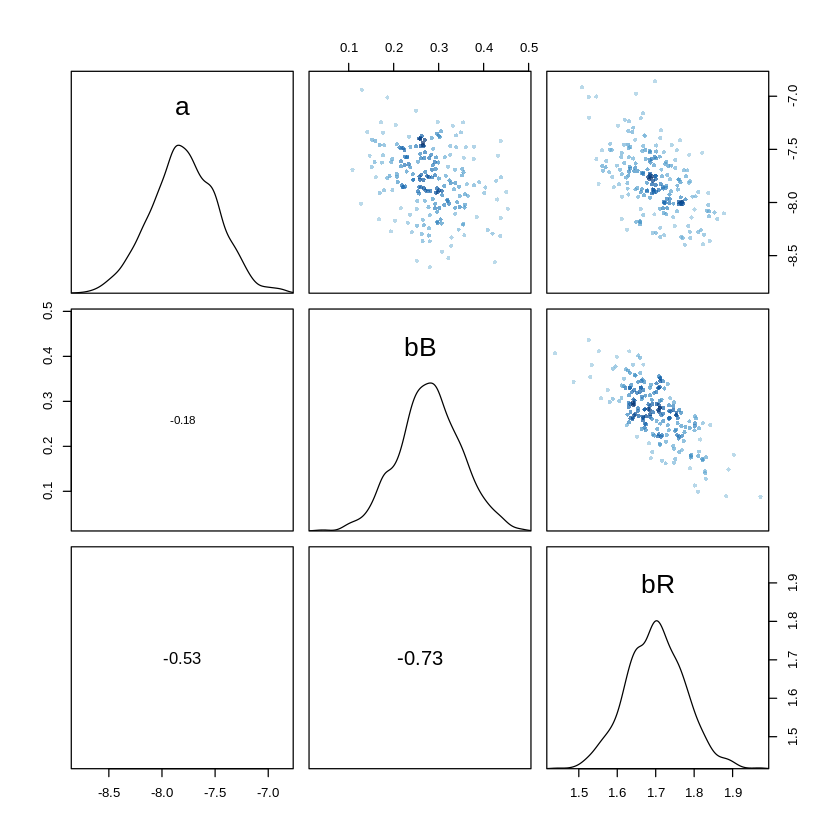

In [84]:
pairs(m_primate5RE)

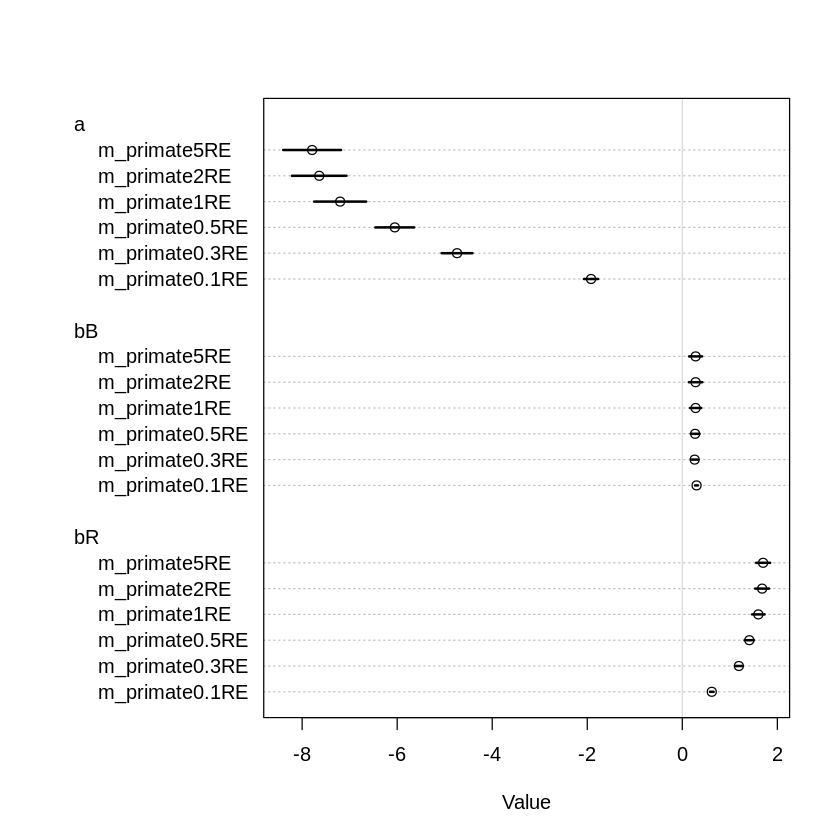

In [68]:
plot(coeftab(m_primate0.1RE, m_primate0.3RE, m_primate0.5RE, m_primate1RE, m_primate2RE, m_primate5RE))

In [80]:
coeftab(m_primate0.1RE, m_primate0.3RE, m_primate0.5RE, m_primate1RE, m_primate2RE, m_primate5RE)

     m_primate0.1RE m_primate0.3RE m_primate0.5RE m_primate1RE m_primate2RE
a      -1.92          -4.74          -6.05          -7.20        -7.64     
bB      0.30           0.26           0.27           0.28         0.28     
bR      0.62           1.19           1.41           1.60         1.68     
nobs     150            150            150            150          150     
     m_primate5RE
a      -7.79     
bB      0.28     
bR      1.70     
nobs     150     

The research effort appears to have overtaken the brain size as the stronger influence on social learning.  bB is now quite stable among the different prior choices at 0.3, so a 1% increase in brain size corresponds to only a 0.3% increase in social learning.  However, a 1% increase in research effort leads to an increase in social learning that depends on the flatness of the priors, but converges to about 1.7%.  This demonstrates either: a) scientific ignorance (due to a lack of research effort) severely underestimates the social learning capacity of primates, or b) some sort of confound.  If b), what could it be?

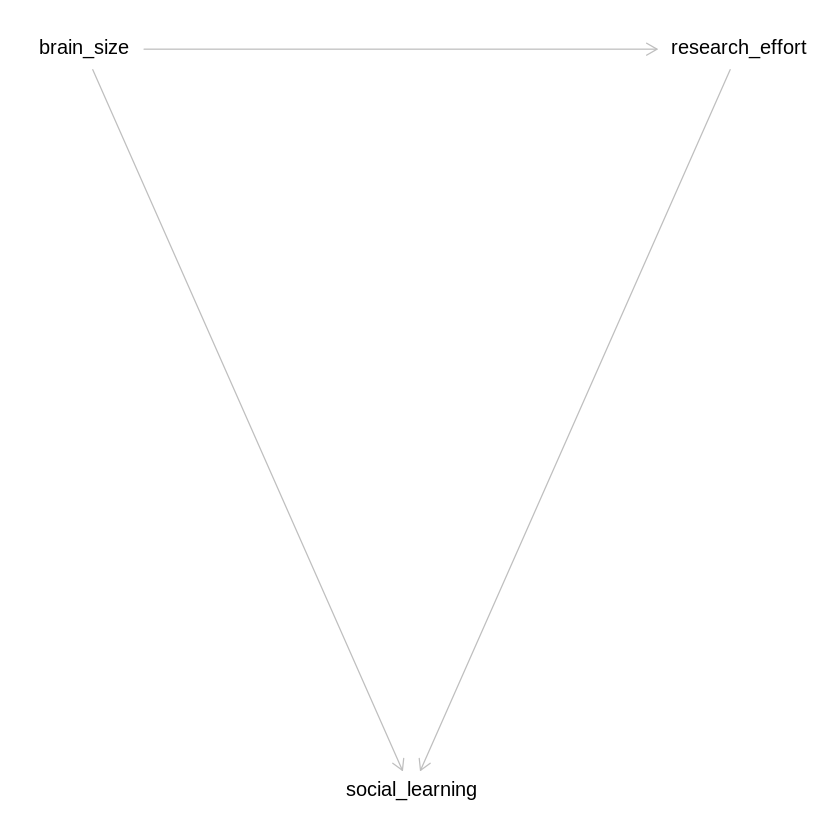

In [98]:
primates_dag2 <- dagitty(
                    "dag {
                            brain_size -> social_learning
                            research_effort -> social_learning
                            brain_size -> research_effort
                        }"
                    )

coordinates( primates_dag2 ) <- list( x=c(brain_size=0,social_learning=0.5,research_effort=1) , y=c(brain_size=0,social_learning=1,research_effort=0) ) 

plot( primates_dag2 )

A lack of research effort may reduce knowledge about social learning and even possibly brain size.  For example, it is likely to cause an underestimation of social learning if complex social interactions have never been observed.  The more research effort, the more likely that the full range of a speices' social learning (whatever that is) is witnessed.

With regards to brain size, reduced research effort means greater uncertainty in the estimates of the brain size, most likely leaving out extreme cases of very small and very large brains (although larger brains may be rarer, due to energetic requirements?  or because there are plenty of juveline primates with smaller brains???).  In this case, perhaps brain size is also underestimated when there is a reduced research effort on a particular primate.

ANSWER

In [90]:
library(rethinking)
data(Primates301)
d <- Primates301
d2 <- d[ complete.cases( d$social_learning , d$brain , d$research_effort ) , ]
dat <- list(
    soc_learn = d2$social_learning,
    log_brain_std = standardize( log(d2$brain) ),
    log_effort = log(d2$research_effort)
)

In [96]:
m3_1 <- ulam(
            alist(
                soc_learn ~ poisson( lambda ),
                log(lambda) <- a + bb*log_brain_std,
                a ~ normal(0,1),
                bb ~ normal(0,0.5)
            ), data=dat , chains=4 , cores=4, log_lik=TRUE )

precis( m3_1 )

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,-1.178865,0.11225710,-1.360285,-1.005669,409.0073,1.005023
bb,2.764064,0.07227042,2.650610,2.884069,434.7184,1.005007


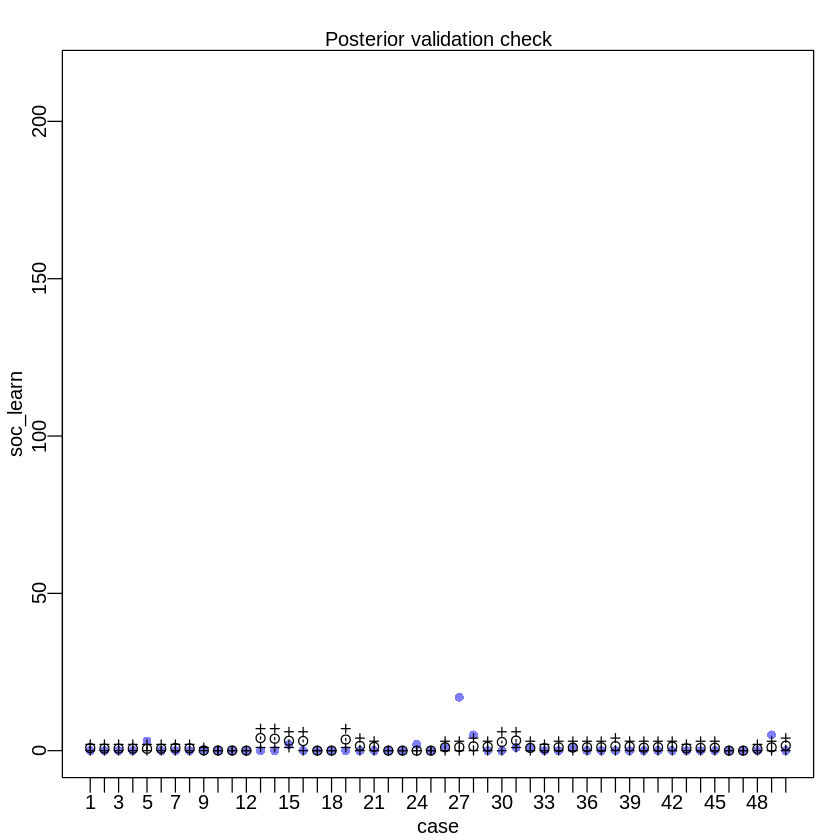

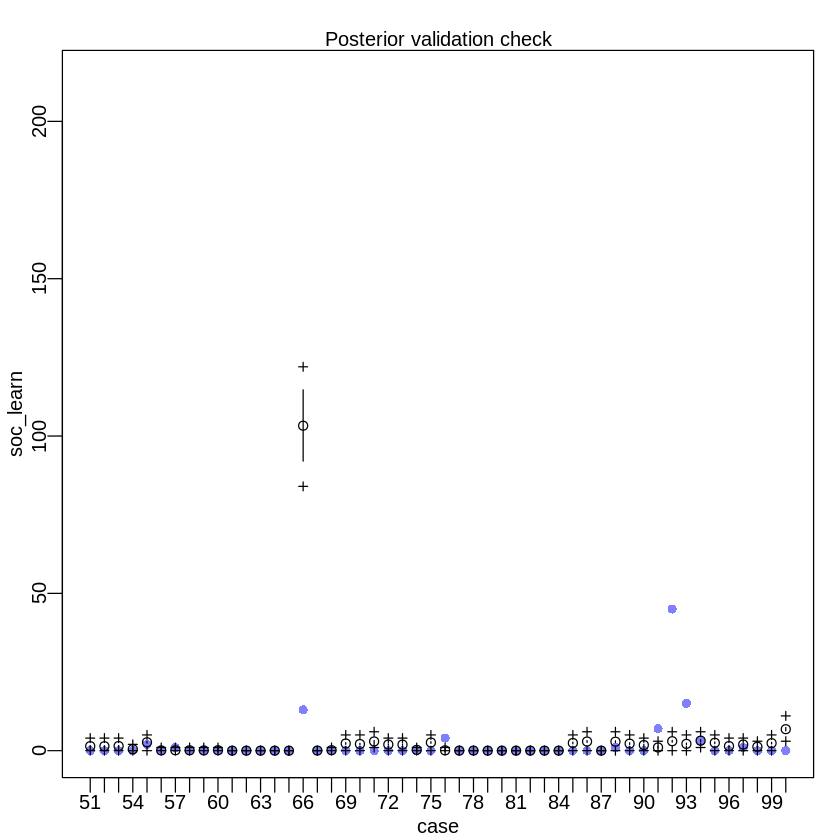

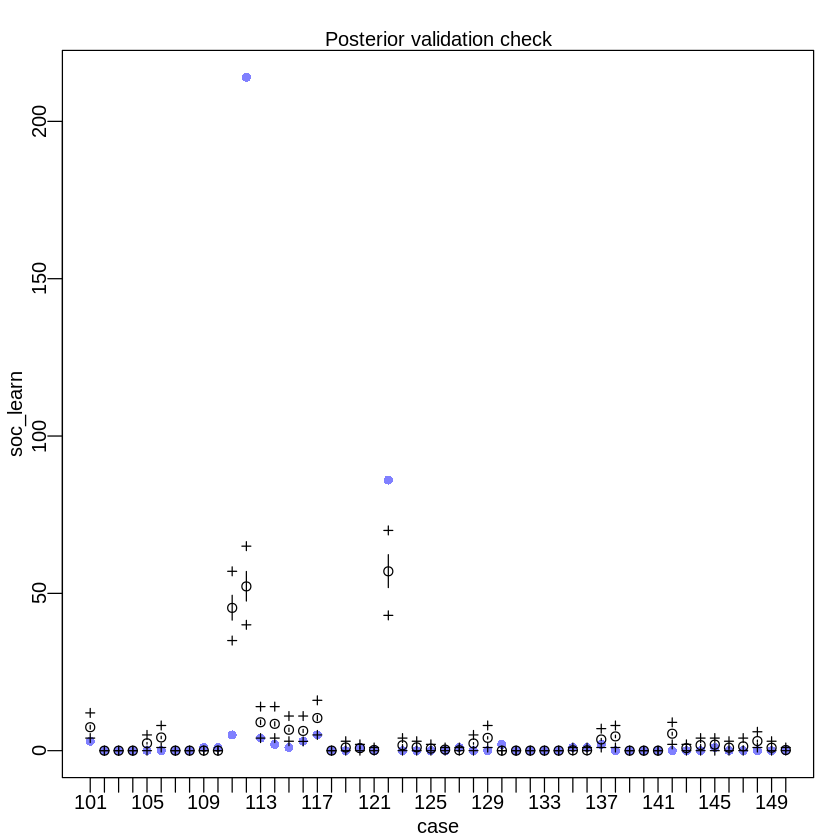

In [92]:
postcheck(m3_1,window=50)

The blue points are the raw data, recall. These are not great posterior predictions.
Clearly other factors are in play.

In [95]:
m3_2 <- ulam(
            alist(
                soc_learn ~ poisson( lambda ),
                log(lambda) <- a + be*log_effort + bb*log_brain_std,
                a ~ normal(0,1),
                c(bb,be) ~ normal(0,0.5)
            ), data=dat , chains=4 , cores=4, log_lik=TRUE )

precis( m3_2 )

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
a,-5.9551934,0.29606667,-6.4227201,-5.4942466,485.2046,1.006592
be,1.5305037,0.06167476,1.4311817,1.6281273,437.7457,1.008030
bb,0.4605155,0.07599898,0.3432957,0.5801172,479.0482,1.006742


integer(0)

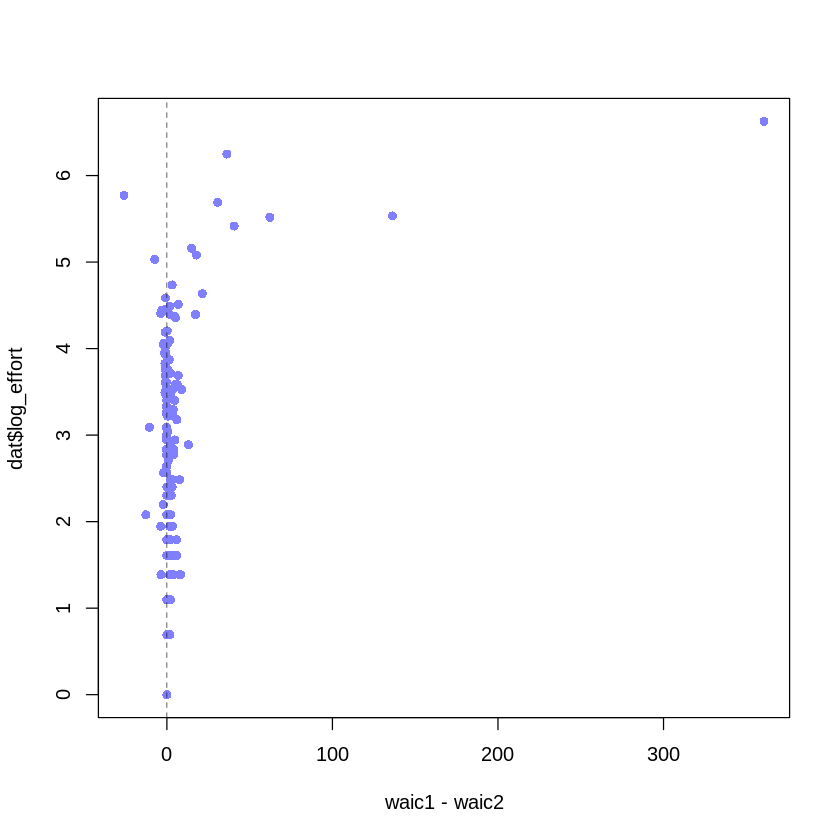

In [97]:
waic1 <- WAIC( m3_1 , pointwise=TRUE )
waic2 <- WAIC( m3_2 , pointwise=TRUE )
plot( waic1 - waic2 , dat$log_effort , col=rangi2 , pch=16 )
identify( waic1-waic2 , dat$log_effort , d2$genus , cex=0.8 )
abline(v=0,lty=2,lwd=0.5)

From the author:

"This is a good example of how the nature of measurement influences inference.
There are likely a lot of false zeros in these data, species that are not studied often
enough to get a good idea of their learning tendencies. Meanwhile every time a
chimpanzee sneezes, someone writes a social learning paper...


Research effort doesn’t
actually influence social learning, but it does influence the value of the variable. The
model results above are consistent with this DAG in the sense that including E reduced the association with B, which we would expect when we close the indirect
path through E. If researchers choose to look for social learning in species with large
brains, this leads to an exaggerated estimate of the association between brains and
social learning."